In [1]:
import pandas as pd
import numpy as np
import folium
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF, PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import xgboost as xgb
from src.nlp_helpers import *
from src.model_helpers import *
from sklearn.model_selection import cross_validate as cv
from sklearn.pipeline import make_pipeline

In [2]:
data = pd.read_csv('data/AB_NYC_2019.csv')

In [3]:
data['last_review'].fillna('None', inplace=True)
data['reviews_per_month'].fillna(0.0, inplace=True)
data['name'].fillna('Unknown', inplace=True)
data['host_name'].fillna('Unknown', inplace=True)
data = data[data['price']<250]

In [4]:
data

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,None,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,None,0.00,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,None,0.00,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,None,0.00,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,None,0.00,6,2


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42669 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              42669 non-null  int64  
 1   name                            42669 non-null  object 
 2   host_id                         42669 non-null  int64  
 3   host_name                       42669 non-null  object 
 4   neighbourhood_group             42669 non-null  object 
 5   neighbourhood                   42669 non-null  object 
 6   latitude                        42669 non-null  float64
 7   longitude                       42669 non-null  float64
 8   room_type                       42669 non-null  object 
 9   price                           42669 non-null  int64  
 10  minimum_nights                  42669 non-null  int64  
 11  number_of_reviews               42669 non-null  int64  
 12  last_review                     

In [6]:
data = data.merge(pd.get_dummies(data['room_type']), left_index=True, right_index=True)
data.drop(columns = 'room_type', inplace=True)

In [7]:
vectorizer, vocab = text_vectorizer(data['name'], use_tfidf=False, use_stemmer=True)
X = vectorizer(data['name'])

/Users/skylarenglish/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [8]:
X = np.column_stack((data['latitude'], data['longitude'], data['minimum_nights'], data['number_of_reviews'], data['reviews_per_month'], data['calculated_host_listings_count'], data['availability_365'], data['Entire home/apt'], data['Private room'], data['Shared room'], X))
y = data['price'].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=123)

In [10]:
pipe = make_pipeline(StandardScaler(),PCA(n_components=250))

In [12]:
X_train = pipe.fit_transform(X_train)

In [17]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1, max_depth=3, alpha=10, n_estimators=50)
xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071', 'f1072', 'f1073', 'f1074', 'f1075', 'f1076', 'f1077', 'f1078', 'f1079', 'f1080', 'f1081', 'f1082', 'f1083', 'f1084', 'f1085', 'f1086', 'f1087', 'f1088', 'f1089', 'f1090', 'f1091', 'f1092', 'f1093', 'f1094', 'f1095', 'f1096', 'f1097', 'f1098', 'f1099', 'f1100', 'f1101', 'f1102', 'f1103', 'f1104', 'f1105', 'f1106', 'f1107', 'f1108', 'f1109', 'f1110', 'f1111', 'f1112', 'f1113', 'f1114', 'f1115', 'f1116', 'f1117', 'f1118', 'f1119', 'f1120', 'f1121', 'f1122', 'f1123', 'f1124', 'f1125', 'f1126', 'f1127', 'f1128', 'f1129', 'f1130', 'f1131', 'f1132', 'f1133', 'f1134', 'f1135', 'f1136', 'f1137', 'f1138', 'f1139', 'f1140', 'f1141', 'f1142', 'f1143', 'f1144', 'f1145', 'f1146', 'f1147', 'f1148', 'f1149', 'f1150', 'f1151', 'f1152', 'f1153', 'f1154', 'f1155', 'f1156', 'f1157', 'f1158', 'f1159', 'f1160', 'f1161', 'f1162', 'f1163', 'f1164', 'f1165', 'f1166', 'f1167', 'f1168', 'f1169', 'f1170', 'f1171', 'f1172', 'f1173', 'f1174', 'f1175', 'f1176', 'f1177', 'f1178', 'f1179', 'f1180', 'f1181', 'f1182', 'f1183', 'f1184', 'f1185', 'f1186', 'f1187', 'f1188', 'f1189', 'f1190', 'f1191', 'f1192', 'f1193', 'f1194', 'f1195', 'f1196', 'f1197', 'f1198', 'f1199', 'f1200', 'f1201', 'f1202', 'f1203', 'f1204', 'f1205', 'f1206', 'f1207', 'f1208', 'f1209', 'f1210', 'f1211', 'f1212', 'f1213', 'f1214', 'f1215', 'f1216', 'f1217', 'f1218', 'f1219', 'f1220', 'f1221', 'f1222', 'f1223', 'f1224', 'f1225', 'f1226', 'f1227', 'f1228', 'f1229', 'f1230', 'f1231', 'f1232', 'f1233', 'f1234', 'f1235', 'f1236', 'f1237', 'f1238', 'f1239', 'f1240', 'f1241', 'f1242', 'f1243', 'f1244', 'f1245', 'f1246', 'f1247', 'f1248', 'f1249', 'f1250', 'f1251', 'f1252', 'f1253', 'f1254', 'f1255', 'f1256', 'f1257', 'f1258', 'f1259', 'f1260', 'f1261', 'f1262', 'f1263', 'f1264', 'f1265', 'f1266', 'f1267', 'f1268', 'f1269', 'f1270', 'f1271', 'f1272', 'f1273', 'f1274', 'f1275', 'f1276', 'f1277', 'f1278', 'f1279', 'f1280', 'f1281', 'f1282', 'f1283', 'f1284', 'f1285', 'f1286', 'f1287', 'f1288', 'f1289', 'f1290', 'f1291', 'f1292', 'f1293', 'f1294', 'f1295', 'f1296', 'f1297', 'f1298', 'f1299', 'f1300', 'f1301', 'f1302', 'f1303', 'f1304', 'f1305', 'f1306', 'f1307', 'f1308', 'f1309', 'f1310', 'f1311', 'f1312', 'f1313', 'f1314', 'f1315', 'f1316', 'f1317', 'f1318', 'f1319', 'f1320', 'f1321', 'f1322', 'f1323', 'f1324', 'f1325', 'f1326', 'f1327', 'f1328', 'f1329', 'f1330', 'f1331', 'f1332', 'f1333', 'f1334', 'f1335', 'f1336', 'f1337', 'f1338', 'f1339', 'f1340', 'f1341', 'f1342', 'f1343', 'f1344', 'f1345', 'f1346', 'f1347', 'f1348', 'f1349', 'f1350', 'f1351', 'f1352', 'f1353', 'f1354', 'f1355', 'f1356', 'f1357', 'f1358', 'f1359', 'f1360', 'f1361', 'f1362', 'f1363', 'f1364', 'f1365', 'f1366', 'f1367', 'f1368', 'f1369', 'f1370', 'f1371', 'f1372', 'f1373', 'f1374', 'f1375', 'f1376', 'f1377', 'f1378', 'f1379', 'f1380', 'f1381', 'f1382', 'f1383', 'f1384', 'f1385', 'f1386', 'f1387', 'f1388', 'f1389', 'f1390', 'f1391', 'f1392', 'f1393', 'f1394', 'f1395', 'f1396', 'f1397', 'f1398', 'f1399', 'f1400', 'f1401', 'f1402', 'f1403', 'f1404', 'f1405', 'f1406', 'f1407', 'f1408', 'f1409', 'f1410', 'f1411', 'f1412', 'f1413', 'f1414', 'f1415', 'f1416', 'f1417', 'f1418', 'f1419', 'f1420', 'f1421', 'f1422', 'f1423', 'f1424', 'f1425', 'f1426', 'f1427', 'f1428', 'f1429', 'f1430', 'f1431', 'f1432', 'f1433', 'f1434', 'f1435', 'f1436', 'f1437', 'f1438', 'f1439', 'f1440', 'f1441', 'f1442', 'f1443', 'f1444', 'f1445', 'f1446', 'f1447', 'f1448', 'f1449', 'f1450', 'f1451', 'f1452', 'f1453', 'f1454', 'f1455', 'f1456', 'f1457', 'f1458', 'f1459', 'f1460', 'f1461', 'f1462', 'f1463', 'f1464', 'f1465', 'f1466', 'f1467', 'f1468', 'f1469', 'f1470', 'f1471', 'f1472', 'f1473', 'f1474', 'f1475', 'f1476', 'f1477', 'f1478', 'f1479', 'f1480', 'f1481', 'f1482', 'f1483', 'f1484', 'f1485', 'f1486', 'f1487', 'f1488', 'f1489', 'f1490', 'f1491', 'f1492', 'f1493', 'f1494', 'f1495', 'f1496', 'f1497', 'f1498', 'f1499', 'f1500', 'f1501', 'f1502', 'f1503', 'f1504', 'f1505', 'f1506', 'f1507', 'f1508', 'f1509', 'f1510', 'f1511', 'f1512', 'f1513', 'f1514', 'f1515', 'f1516', 'f1517', 'f1518', 'f1519', 'f1520', 'f1521', 'f1522', 'f1523', 'f1524', 'f1525', 'f1526', 'f1527', 'f1528', 'f1529', 'f1530', 'f1531', 'f1532', 'f1533', 'f1534', 'f1535', 'f1536', 'f1537', 'f1538', 'f1539', 'f1540', 'f1541', 'f1542', 'f1543', 'f1544', 'f1545', 'f1546', 'f1547', 'f1548', 'f1549', 'f1550', 'f1551', 'f1552', 'f1553', 'f1554', 'f1555', 'f1556', 'f1557', 'f1558', 'f1559', 'f1560', 'f1561', 'f1562', 'f1563', 'f1564', 'f1565', 'f1566', 'f1567', 'f1568', 'f1569', 'f1570', 'f1571', 'f1572', 'f1573', 'f1574', 'f1575', 'f1576', 'f1577', 'f1578', 'f1579', 'f1580', 'f1581', 'f1582', 'f1583', 'f1584', 'f1585', 'f1586', 'f1587', 'f1588', 'f1589', 'f1590', 'f1591', 'f1592', 'f1593', 'f1594', 'f1595', 'f1596', 'f1597', 'f1598', 'f1599', 'f1600', 'f1601', 'f1602', 'f1603', 'f1604', 'f1605', 'f1606', 'f1607', 'f1608', 'f1609', 'f1610', 'f1611', 'f1612', 'f1613', 'f1614', 'f1615', 'f1616', 'f1617', 'f1618', 'f1619', 'f1620', 'f1621', 'f1622', 'f1623', 'f1624', 'f1625', 'f1626', 'f1627', 'f1628', 'f1629', 'f1630', 'f1631', 'f1632', 'f1633', 'f1634', 'f1635', 'f1636', 'f1637', 'f1638', 'f1639', 'f1640', 'f1641', 'f1642', 'f1643', 'f1644', 'f1645', 'f1646', 'f1647', 'f1648', 'f1649', 'f1650', 'f1651', 'f1652', 'f1653', 'f1654', 'f1655', 'f1656', 'f1657', 'f1658', 'f1659', 'f1660', 'f1661', 'f1662', 'f1663', 'f1664', 'f1665', 'f1666', 'f1667', 'f1668', 'f1669', 'f1670', 'f1671', 'f1672', 'f1673', 'f1674', 'f1675', 'f1676', 'f1677', 'f1678', 'f1679', 'f1680', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686', 'f1687', 'f1688', 'f1689', 'f1690', 'f1691', 'f1692', 'f1693', 'f1694', 'f1695', 'f1696', 'f1697', 'f1698', 'f1699', 'f1700', 'f1701', 'f1702', 'f1703', 'f1704', 'f1705', 'f1706', 'f1707', 'f1708', 'f1709', 'f1710', 'f1711', 'f1712', 'f1713', 'f1714', 'f1715', 'f1716', 'f1717', 'f1718', 'f1719', 'f1720', 'f1721', 'f1722', 'f1723', 'f1724', 'f1725', 'f1726', 'f1727', 'f1728', 'f1729', 'f1730', 'f1731', 'f1732', 'f1733', 'f1734', 'f1735', 'f1736', 'f1737', 'f1738', 'f1739', 'f1740', 'f1741', 'f1742', 'f1743', 'f1744', 'f1745', 'f1746', 'f1747', 'f1748', 'f1749', 'f1750', 'f1751', 'f1752', 'f1753', 'f1754', 'f1755', 'f1756', 'f1757', 'f1758', 'f1759', 'f1760', 'f1761', 'f1762', 'f1763', 'f1764', 'f1765', 'f1766', 'f1767', 'f1768', 'f1769', 'f1770', 'f1771', 'f1772', 'f1773', 'f1774', 'f1775', 'f1776', 'f1777', 'f1778', 'f1779', 'f1780', 'f1781', 'f1782', 'f1783', 'f1784', 'f1785', 'f1786', 'f1787', 'f1788', 'f1789', 'f1790', 'f1791', 'f1792', 'f1793', 'f1794', 'f1795', 'f1796', 'f1797', 'f1798', 'f1799', 'f1800', 'f1801', 'f1802', 'f1803', 'f1804', 'f1805', 'f1806', 'f1807', 'f1808', 'f1809', 'f1810', 'f1811', 'f1812', 'f1813', 'f1814', 'f1815', 'f1816', 'f1817', 'f1818', 'f1819', 'f1820', 'f1821', 'f1822', 'f1823', 'f1824', 'f1825', 'f1826', 'f1827', 'f1828', 'f1829', 'f1830', 'f1831', 'f1832', 'f1833', 'f1834', 'f1835', 'f1836', 'f1837', 'f1838', 'f1839', 'f1840', 'f1841', 'f1842', 'f1843', 'f1844', 'f1845', 'f1846', 'f1847', 'f1848', 'f1849', 'f1850', 'f1851', 'f1852', 'f1853', 'f1854', 'f1855', 'f1856', 'f1857', 'f1858', 'f1859', 'f1860', 'f1861', 'f1862', 'f1863', 'f1864', 'f1865', 'f1866', 'f1867', 'f1868', 'f1869', 'f1870', 'f1871', 'f1872', 'f1873', 'f1874', 'f1875', 'f1876', 'f1877', 'f1878', 'f1879', 'f1880', 'f1881', 'f1882', 'f1883', 'f1884', 'f1885', 'f1886', 'f1887', 'f1888', 'f1889', 'f1890', 'f1891', 'f1892', 'f1893', 'f1894', 'f1895', 'f1896', 'f1897', 'f1898', 'f1899', 'f1900', 'f1901', 'f1902', 'f1903', 'f1904', 'f1905', 'f1906', 'f1907', 'f1908', 'f1909', 'f1910', 'f1911', 'f1912', 'f1913', 'f1914', 'f1915', 'f1916', 'f1917', 'f1918', 'f1919', 'f1920', 'f1921', 'f1922', 'f1923', 'f1924', 'f1925', 'f1926', 'f1927', 'f1928', 'f1929', 'f1930', 'f1931', 'f1932', 'f1933', 'f1934', 'f1935', 'f1936', 'f1937', 'f1938', 'f1939', 'f1940', 'f1941', 'f1942', 'f1943', 'f1944', 'f1945', 'f1946', 'f1947', 'f1948', 'f1949', 'f1950', 'f1951', 'f1952', 'f1953', 'f1954', 'f1955', 'f1956', 'f1957', 'f1958', 'f1959', 'f1960', 'f1961', 'f1962', 'f1963', 'f1964', 'f1965', 'f1966', 'f1967', 'f1968', 'f1969', 'f1970', 'f1971', 'f1972', 'f1973', 'f1974', 'f1975', 'f1976', 'f1977', 'f1978', 'f1979', 'f1980', 'f1981', 'f1982', 'f1983', 'f1984', 'f1985', 'f1986', 'f1987', 'f1988', 'f1989', 'f1990', 'f1991', 'f1992', 'f1993', 'f1994', 'f1995', 'f1996', 'f1997', 'f1998', 'f1999', 'f2000', 'f2001', 'f2002', 'f2003', 'f2004', 'f2005', 'f2006', 'f2007', 'f2008', 'f2009', 'f2010', 'f2011', 'f2012', 'f2013', 'f2014', 'f2015', 'f2016', 'f2017', 'f2018', 'f2019', 'f2020', 'f2021', 'f2022', 'f2023', 'f2024', 'f2025', 'f2026', 'f2027', 'f2028', 'f2029', 'f2030', 'f2031', 'f2032', 'f2033', 'f2034', 'f2035', 'f2036', 'f2037', 'f2038', 'f2039', 'f2040', 'f2041', 'f2042', 'f2043', 'f2044', 'f2045', 'f2046', 'f2047', 'f2048', 'f2049', 'f2050', 'f2051', 'f2052', 'f2053', 'f2054', 'f2055', 'f2056', 'f2057', 'f2058', 'f2059', 'f2060', 'f2061', 'f2062', 'f2063', 'f2064', 'f2065', 'f2066', 'f2067', 'f2068', 'f2069', 'f2070', 'f2071', 'f2072', 'f2073', 'f2074', 'f2075', 'f2076', 'f2077', 'f2078', 'f2079', 'f2080', 'f2081', 'f2082', 'f2083', 'f2084', 'f2085', 'f2086', 'f2087', 'f2088', 'f2089', 'f2090', 'f2091', 'f2092', 'f2093', 'f2094', 'f2095', 'f2096', 'f2097', 'f2098', 'f2099', 'f2100', 'f2101', 'f2102', 'f2103', 'f2104', 'f2105', 'f2106', 'f2107', 'f2108', 'f2109', 'f2110', 'f2111', 'f2112', 'f2113', 'f2114', 'f2115', 'f2116', 'f2117', 'f2118', 'f2119', 'f2120', 'f2121', 'f2122', 'f2123', 'f2124', 'f2125', 'f2126', 'f2127', 'f2128', 'f2129', 'f2130', 'f2131', 'f2132', 'f2133', 'f2134', 'f2135', 'f2136', 'f2137', 'f2138', 'f2139', 'f2140', 'f2141', 'f2142', 'f2143', 'f2144', 'f2145', 'f2146', 'f2147', 'f2148', 'f2149', 'f2150', 'f2151', 'f2152', 'f2153', 'f2154', 'f2155', 'f2156', 'f2157', 'f2158', 'f2159', 'f2160', 'f2161', 'f2162', 'f2163', 'f2164', 'f2165', 'f2166', 'f2167', 'f2168', 'f2169', 'f2170', 'f2171', 'f2172', 'f2173', 'f2174', 'f2175', 'f2176', 'f2177', 'f2178', 'f2179', 'f2180', 'f2181', 'f2182', 'f2183', 'f2184', 'f2185', 'f2186', 'f2187', 'f2188', 'f2189', 'f2190', 'f2191', 'f2192', 'f2193', 'f2194', 'f2195', 'f2196', 'f2197', 'f2198', 'f2199', 'f2200', 'f2201', 'f2202', 'f2203', 'f2204', 'f2205', 'f2206', 'f2207', 'f2208', 'f2209', 'f2210', 'f2211', 'f2212', 'f2213', 'f2214', 'f2215', 'f2216', 'f2217', 'f2218', 'f2219', 'f2220', 'f2221', 'f2222', 'f2223', 'f2224', 'f2225', 'f2226', 'f2227', 'f2228', 'f2229', 'f2230', 'f2231', 'f2232', 'f2233', 'f2234', 'f2235', 'f2236', 'f2237', 'f2238', 'f2239', 'f2240', 'f2241', 'f2242', 'f2243', 'f2244', 'f2245', 'f2246', 'f2247', 'f2248', 'f2249', 'f2250', 'f2251', 'f2252', 'f2253', 'f2254', 'f2255', 'f2256', 'f2257', 'f2258', 'f2259', 'f2260', 'f2261', 'f2262', 'f2263', 'f2264', 'f2265', 'f2266', 'f2267', 'f2268', 'f2269', 'f2270', 'f2271', 'f2272', 'f2273', 'f2274', 'f2275', 'f2276', 'f2277', 'f2278', 'f2279', 'f2280', 'f2281', 'f2282', 'f2283', 'f2284', 'f2285', 'f2286', 'f2287', 'f2288', 'f2289', 'f2290', 'f2291', 'f2292', 'f2293', 'f2294', 'f2295', 'f2296', 'f2297', 'f2298', 'f2299', 'f2300', 'f2301', 'f2302', 'f2303', 'f2304', 'f2305', 'f2306', 'f2307', 'f2308', 'f2309', 'f2310', 'f2311', 'f2312', 'f2313', 'f2314', 'f2315', 'f2316', 'f2317', 'f2318', 'f2319', 'f2320', 'f2321', 'f2322', 'f2323', 'f2324', 'f2325', 'f2326', 'f2327', 'f2328', 'f2329', 'f2330', 'f2331', 'f2332', 'f2333', 'f2334', 'f2335', 'f2336', 'f2337', 'f2338', 'f2339', 'f2340', 'f2341', 'f2342', 'f2343', 'f2344', 'f2345', 'f2346', 'f2347', 'f2348', 'f2349', 'f2350', 'f2351', 'f2352', 'f2353', 'f2354', 'f2355', 'f2356', 'f2357', 'f2358', 'f2359', 'f2360', 'f2361', 'f2362', 'f2363', 'f2364', 'f2365', 'f2366', 'f2367', 'f2368', 'f2369', 'f2370', 'f2371', 'f2372', 'f2373', 'f2374', 'f2375', 'f2376', 'f2377', 'f2378', 'f2379', 'f2380', 'f2381', 'f2382', 'f2383', 'f2384', 'f2385', 'f2386', 'f2387', 'f2388', 'f2389', 'f2390', 'f2391', 'f2392', 'f2393', 'f2394', 'f2395', 'f2396', 'f2397', 'f2398', 'f2399', 'f2400', 'f2401', 'f2402', 'f2403', 'f2404', 'f2405', 'f2406', 'f2407', 'f2408', 'f2409', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415', 'f2416', 'f2417', 'f2418', 'f2419', 'f2420', 'f2421', 'f2422', 'f2423', 'f2424', 'f2425', 'f2426', 'f2427', 'f2428', 'f2429', 'f2430', 'f2431', 'f2432', 'f2433', 'f2434', 'f2435', 'f2436', 'f2437', 'f2438', 'f2439', 'f2440', 'f2441', 'f2442', 'f2443', 'f2444', 'f2445', 'f2446', 'f2447', 'f2448', 'f2449', 'f2450', 'f2451', 'f2452', 'f2453', 'f2454', 'f2455', 'f2456', 'f2457', 'f2458', 'f2459', 'f2460', 'f2461', 'f2462', 'f2463', 'f2464', 'f2465', 'f2466', 'f2467', 'f2468', 'f2469', 'f2470', 'f2471', 'f2472', 'f2473', 'f2474', 'f2475', 'f2476', 'f2477', 'f2478', 'f2479', 'f2480', 'f2481', 'f2482', 'f2483', 'f2484', 'f2485', 'f2486', 'f2487', 'f2488', 'f2489', 'f2490', 'f2491', 'f2492', 'f2493', 'f2494', 'f2495', 'f2496', 'f2497', 'f2498', 'f2499', 'f2500', 'f2501', 'f2502', 'f2503', 'f2504', 'f2505', 'f2506', 'f2507', 'f2508', 'f2509', 'f2510', 'f2511', 'f2512', 'f2513', 'f2514', 'f2515', 'f2516', 'f2517', 'f2518', 'f2519', 'f2520', 'f2521', 'f2522', 'f2523', 'f2524', 'f2525', 'f2526', 'f2527', 'f2528', 'f2529', 'f2530', 'f2531', 'f2532', 'f2533', 'f2534', 'f2535', 'f2536', 'f2537', 'f2538', 'f2539', 'f2540', 'f2541', 'f2542', 'f2543', 'f2544', 'f2545', 'f2546', 'f2547', 'f2548', 'f2549', 'f2550', 'f2551', 'f2552', 'f2553', 'f2554', 'f2555', 'f2556', 'f2557', 'f2558', 'f2559', 'f2560', 'f2561', 'f2562', 'f2563', 'f2564', 'f2565', 'f2566', 'f2567', 'f2568', 'f2569', 'f2570', 'f2571', 'f2572', 'f2573', 'f2574', 'f2575', 'f2576', 'f2577', 'f2578', 'f2579', 'f2580', 'f2581', 'f2582', 'f2583', 'f2584', 'f2585', 'f2586', 'f2587', 'f2588', 'f2589', 'f2590', 'f2591', 'f2592', 'f2593', 'f2594', 'f2595', 'f2596', 'f2597', 'f2598', 'f2599', 'f2600', 'f2601', 'f2602', 'f2603', 'f2604', 'f2605', 'f2606', 'f2607', 'f2608', 'f2609', 'f2610', 'f2611', 'f2612', 'f2613', 'f2614', 'f2615', 'f2616', 'f2617', 'f2618', 'f2619', 'f2620', 'f2621', 'f2622', 'f2623', 'f2624', 'f2625', 'f2626', 'f2627', 'f2628', 'f2629', 'f2630', 'f2631', 'f2632', 'f2633', 'f2634', 'f2635', 'f2636', 'f2637', 'f2638', 'f2639', 'f2640', 'f2641', 'f2642', 'f2643', 'f2644', 'f2645', 'f2646', 'f2647', 'f2648', 'f2649', 'f2650', 'f2651', 'f2652', 'f2653', 'f2654', 'f2655', 'f2656', 'f2657', 'f2658', 'f2659', 'f2660', 'f2661', 'f2662', 'f2663', 'f2664', 'f2665', 'f2666', 'f2667', 'f2668', 'f2669', 'f2670', 'f2671', 'f2672', 'f2673', 'f2674', 'f2675', 'f2676', 'f2677', 'f2678', 'f2679', 'f2680', 'f2681', 'f2682', 'f2683', 'f2684', 'f2685', 'f2686', 'f2687', 'f2688', 'f2689', 'f2690', 'f2691', 'f2692', 'f2693', 'f2694', 'f2695', 'f2696', 'f2697', 'f2698', 'f2699', 'f2700', 'f2701', 'f2702', 'f2703', 'f2704', 'f2705', 'f2706', 'f2707', 'f2708', 'f2709', 'f2710', 'f2711', 'f2712', 'f2713', 'f2714', 'f2715', 'f2716', 'f2717', 'f2718', 'f2719', 'f2720', 'f2721', 'f2722', 'f2723', 'f2724', 'f2725', 'f2726', 'f2727', 'f2728', 'f2729', 'f2730', 'f2731', 'f2732', 'f2733', 'f2734', 'f2735', 'f2736', 'f2737', 'f2738', 'f2739', 'f2740', 'f2741', 'f2742', 'f2743', 'f2744', 'f2745', 'f2746', 'f2747', 'f2748', 'f2749', 'f2750', 'f2751', 'f2752', 'f2753', 'f2754', 'f2755', 'f2756', 'f2757', 'f2758', 'f2759', 'f2760', 'f2761', 'f2762', 'f2763', 'f2764', 'f2765', 'f2766', 'f2767', 'f2768', 'f2769', 'f2770', 'f2771', 'f2772', 'f2773', 'f2774', 'f2775', 'f2776', 'f2777', 'f2778', 'f2779', 'f2780', 'f2781', 'f2782', 'f2783', 'f2784', 'f2785', 'f2786', 'f2787', 'f2788', 'f2789', 'f2790', 'f2791', 'f2792', 'f2793', 'f2794', 'f2795', 'f2796', 'f2797', 'f2798', 'f2799', 'f2800', 'f2801', 'f2802', 'f2803', 'f2804', 'f2805', 'f2806', 'f2807', 'f2808', 'f2809', 'f2810', 'f2811', 'f2812', 'f2813', 'f2814', 'f2815', 'f2816', 'f2817', 'f2818', 'f2819', 'f2820', 'f2821', 'f2822', 'f2823', 'f2824', 'f2825', 'f2826', 'f2827', 'f2828', 'f2829', 'f2830', 'f2831', 'f2832', 'f2833', 'f2834', 'f2835', 'f2836', 'f2837', 'f2838', 'f2839', 'f2840', 'f2841', 'f2842', 'f2843', 'f2844', 'f2845', 'f2846', 'f2847', 'f2848', 'f2849', 'f2850', 'f2851', 'f2852', 'f2853', 'f2854', 'f2855', 'f2856', 'f2857', 'f2858', 'f2859', 'f2860', 'f2861', 'f2862', 'f2863', 'f2864', 'f2865', 'f2866', 'f2867', 'f2868', 'f2869', 'f2870', 'f2871', 'f2872', 'f2873', 'f2874', 'f2875', 'f2876', 'f2877', 'f2878', 'f2879', 'f2880', 'f2881', 'f2882', 'f2883', 'f2884', 'f2885', 'f2886', 'f2887', 'f2888', 'f2889', 'f2890', 'f2891', 'f2892', 'f2893', 'f2894', 'f2895', 'f2896', 'f2897', 'f2898', 'f2899', 'f2900', 'f2901', 'f2902', 'f2903', 'f2904', 'f2905', 'f2906', 'f2907', 'f2908', 'f2909', 'f2910', 'f2911', 'f2912', 'f2913', 'f2914', 'f2915', 'f2916', 'f2917', 'f2918', 'f2919', 'f2920', 'f2921', 'f2922', 'f2923', 'f2924', 'f2925', 'f2926', 'f2927', 'f2928', 'f2929', 'f2930', 'f2931', 'f2932', 'f2933', 'f2934', 'f2935', 'f2936', 'f2937', 'f2938', 'f2939', 'f2940', 'f2941', 'f2942', 'f2943', 'f2944', 'f2945', 'f2946', 'f2947', 'f2948', 'f2949', 'f2950', 'f2951', 'f2952', 'f2953', 'f2954', 'f2955', 'f2956', 'f2957', 'f2958', 'f2959', 'f2960', 'f2961', 'f2962', 'f2963', 'f2964', 'f2965', 'f2966', 'f2967', 'f2968', 'f2969', 'f2970', 'f2971', 'f2972', 'f2973', 'f2974', 'f2975', 'f2976', 'f2977', 'f2978', 'f2979', 'f2980', 'f2981', 'f2982', 'f2983', 'f2984', 'f2985', 'f2986', 'f2987', 'f2988', 'f2989', 'f2990', 'f2991', 'f2992', 'f2993', 'f2994', 'f2995', 'f2996', 'f2997', 'f2998', 'f2999', 'f3000', 'f3001', 'f3002', 'f3003', 'f3004', 'f3005', 'f3006', 'f3007', 'f3008', 'f3009', 'f3010', 'f3011', 'f3012', 'f3013', 'f3014', 'f3015', 'f3016', 'f3017', 'f3018', 'f3019', 'f3020', 'f3021', 'f3022', 'f3023', 'f3024', 'f3025', 'f3026', 'f3027', 'f3028', 'f3029', 'f3030', 'f3031', 'f3032', 'f3033', 'f3034', 'f3035', 'f3036', 'f3037', 'f3038', 'f3039', 'f3040', 'f3041', 'f3042', 'f3043', 'f3044', 'f3045', 'f3046', 'f3047', 'f3048', 'f3049', 'f3050', 'f3051', 'f3052', 'f3053', 'f3054', 'f3055', 'f3056', 'f3057', 'f3058', 'f3059', 'f3060', 'f3061', 'f3062', 'f3063', 'f3064', 'f3065', 'f3066', 'f3067', 'f3068', 'f3069', 'f3070', 'f3071', 'f3072', 'f3073', 'f3074', 'f3075', 'f3076', 'f3077', 'f3078', 'f3079', 'f3080', 'f3081', 'f3082', 'f3083', 'f3084', 'f3085', 'f3086', 'f3087', 'f3088', 'f3089', 'f3090', 'f3091', 'f3092', 'f3093', 'f3094', 'f3095', 'f3096', 'f3097', 'f3098', 'f3099', 'f3100', 'f3101', 'f3102', 'f3103', 'f3104', 'f3105', 'f3106', 'f3107', 'f3108', 'f3109', 'f3110', 'f3111', 'f3112', 'f3113', 'f3114', 'f3115', 'f3116', 'f3117', 'f3118', 'f3119', 'f3120', 'f3121', 'f3122', 'f3123', 'f3124', 'f3125', 'f3126', 'f3127', 'f3128', 'f3129', 'f3130', 'f3131', 'f3132', 'f3133', 'f3134', 'f3135', 'f3136', 'f3137', 'f3138', 'f3139', 'f3140', 'f3141', 'f3142', 'f3143', 'f3144', 'f3145', 'f3146', 'f3147', 'f3148', 'f3149', 'f3150', 'f3151', 'f3152', 'f3153', 'f3154', 'f3155', 'f3156', 'f3157', 'f3158', 'f3159', 'f3160', 'f3161', 'f3162', 'f3163', 'f3164', 'f3165', 'f3166', 'f3167', 'f3168', 'f3169', 'f3170', 'f3171', 'f3172', 'f3173', 'f3174', 'f3175', 'f3176', 'f3177', 'f3178', 'f3179', 'f3180', 'f3181', 'f3182', 'f3183', 'f3184', 'f3185', 'f3186', 'f3187', 'f3188', 'f3189', 'f3190', 'f3191', 'f3192', 'f3193', 'f3194', 'f3195', 'f3196', 'f3197', 'f3198', 'f3199', 'f3200', 'f3201', 'f3202', 'f3203', 'f3204', 'f3205', 'f3206', 'f3207', 'f3208', 'f3209', 'f3210', 'f3211', 'f3212', 'f3213', 'f3214', 'f3215', 'f3216', 'f3217', 'f3218', 'f3219', 'f3220', 'f3221', 'f3222', 'f3223', 'f3224', 'f3225', 'f3226', 'f3227', 'f3228', 'f3229', 'f3230', 'f3231', 'f3232', 'f3233', 'f3234', 'f3235', 'f3236', 'f3237', 'f3238', 'f3239', 'f3240', 'f3241', 'f3242', 'f3243', 'f3244', 'f3245', 'f3246', 'f3247', 'f3248', 'f3249', 'f3250', 'f3251', 'f3252', 'f3253', 'f3254', 'f3255', 'f3256', 'f3257', 'f3258', 'f3259', 'f3260', 'f3261', 'f3262', 'f3263', 'f3264', 'f3265', 'f3266', 'f3267', 'f3268', 'f3269', 'f3270', 'f3271', 'f3272', 'f3273', 'f3274', 'f3275', 'f3276', 'f3277', 'f3278', 'f3279', 'f3280', 'f3281', 'f3282', 'f3283', 'f3284', 'f3285', 'f3286', 'f3287', 'f3288', 'f3289', 'f3290', 'f3291', 'f3292', 'f3293', 'f3294', 'f3295', 'f3296', 'f3297', 'f3298', 'f3299', 'f3300', 'f3301', 'f3302', 'f3303', 'f3304', 'f3305', 'f3306', 'f3307', 'f3308', 'f3309', 'f3310', 'f3311', 'f3312', 'f3313', 'f3314', 'f3315', 'f3316', 'f3317', 'f3318', 'f3319', 'f3320', 'f3321', 'f3322', 'f3323', 'f3324', 'f3325', 'f3326', 'f3327', 'f3328', 'f3329', 'f3330', 'f3331', 'f3332', 'f3333', 'f3334', 'f3335', 'f3336', 'f3337', 'f3338', 'f3339', 'f3340', 'f3341', 'f3342', 'f3343', 'f3344', 'f3345', 'f3346', 'f3347', 'f3348', 'f3349', 'f3350', 'f3351', 'f3352', 'f3353', 'f3354', 'f3355', 'f3356', 'f3357', 'f3358', 'f3359', 'f3360', 'f3361', 'f3362', 'f3363', 'f3364', 'f3365', 'f3366', 'f3367', 'f3368', 'f3369', 'f3370', 'f3371', 'f3372', 'f3373', 'f3374', 'f3375', 'f3376', 'f3377', 'f3378', 'f3379', 'f3380', 'f3381', 'f3382', 'f3383', 'f3384', 'f3385', 'f3386', 'f3387', 'f3388', 'f3389', 'f3390', 'f3391', 'f3392', 'f3393', 'f3394', 'f3395', 'f3396', 'f3397', 'f3398', 'f3399', 'f3400', 'f3401', 'f3402', 'f3403', 'f3404', 'f3405', 'f3406', 'f3407', 'f3408', 'f3409', 'f3410', 'f3411', 'f3412', 'f3413', 'f3414', 'f3415', 'f3416', 'f3417', 'f3418', 'f3419', 'f3420', 'f3421', 'f3422', 'f3423', 'f3424', 'f3425', 'f3426', 'f3427', 'f3428', 'f3429', 'f3430', 'f3431', 'f3432', 'f3433', 'f3434', 'f3435', 'f3436', 'f3437', 'f3438', 'f3439', 'f3440', 'f3441', 'f3442', 'f3443', 'f3444', 'f3445', 'f3446', 'f3447', 'f3448', 'f3449', 'f3450', 'f3451', 'f3452', 'f3453', 'f3454', 'f3455', 'f3456', 'f3457', 'f3458', 'f3459', 'f3460', 'f3461', 'f3462', 'f3463', 'f3464', 'f3465', 'f3466', 'f3467', 'f3468', 'f3469', 'f3470', 'f3471', 'f3472', 'f3473', 'f3474', 'f3475', 'f3476', 'f3477', 'f3478', 'f3479', 'f3480', 'f3481', 'f3482', 'f3483', 'f3484', 'f3485', 'f3486', 'f3487', 'f3488', 'f3489', 'f3490', 'f3491', 'f3492', 'f3493', 'f3494', 'f3495', 'f3496', 'f3497', 'f3498', 'f3499', 'f3500', 'f3501', 'f3502', 'f3503', 'f3504', 'f3505', 'f3506', 'f3507', 'f3508', 'f3509', 'f3510', 'f3511', 'f3512', 'f3513', 'f3514', 'f3515', 'f3516', 'f3517', 'f3518', 'f3519', 'f3520', 'f3521', 'f3522', 'f3523', 'f3524', 'f3525', 'f3526', 'f3527', 'f3528', 'f3529', 'f3530', 'f3531', 'f3532', 'f3533', 'f3534', 'f3535', 'f3536', 'f3537', 'f3538', 'f3539', 'f3540', 'f3541', 'f3542', 'f3543', 'f3544', 'f3545', 'f3546', 'f3547', 'f3548', 'f3549', 'f3550', 'f3551', 'f3552', 'f3553', 'f3554', 'f3555', 'f3556', 'f3557', 'f3558', 'f3559', 'f3560', 'f3561', 'f3562', 'f3563', 'f3564', 'f3565', 'f3566', 'f3567', 'f3568', 'f3569', 'f3570', 'f3571', 'f3572', 'f3573', 'f3574', 'f3575', 'f3576', 'f3577', 'f3578', 'f3579', 'f3580', 'f3581', 'f3582', 'f3583', 'f3584', 'f3585', 'f3586', 'f3587', 'f3588', 'f3589', 'f3590', 'f3591', 'f3592', 'f3593', 'f3594', 'f3595', 'f3596', 'f3597', 'f3598', 'f3599', 'f3600', 'f3601', 'f3602', 'f3603', 'f3604', 'f3605', 'f3606', 'f3607', 'f3608', 'f3609', 'f3610', 'f3611', 'f3612', 'f3613', 'f3614', 'f3615', 'f3616', 'f3617', 'f3618', 'f3619', 'f3620', 'f3621', 'f3622', 'f3623', 'f3624', 'f3625', 'f3626', 'f3627', 'f3628', 'f3629', 'f3630', 'f3631', 'f3632', 'f3633', 'f3634', 'f3635', 'f3636', 'f3637', 'f3638', 'f3639', 'f3640', 'f3641', 'f3642', 'f3643', 'f3644', 'f3645', 'f3646', 'f3647', 'f3648', 'f3649', 'f3650', 'f3651', 'f3652', 'f3653', 'f3654', 'f3655', 'f3656', 'f3657', 'f3658', 'f3659', 'f3660', 'f3661', 'f3662', 'f3663', 'f3664', 'f3665', 'f3666', 'f3667', 'f3668', 'f3669', 'f3670', 'f3671', 'f3672', 'f3673', 'f3674', 'f3675', 'f3676', 'f3677', 'f3678', 'f3679', 'f3680', 'f3681', 'f3682', 'f3683', 'f3684', 'f3685', 'f3686', 'f3687', 'f3688', 'f3689', 'f3690', 'f3691', 'f3692', 'f3693', 'f3694', 'f3695', 'f3696', 'f3697', 'f3698', 'f3699', 'f3700', 'f3701', 'f3702', 'f3703', 'f3704', 'f3705', 'f3706', 'f3707', 'f3708', 'f3709', 'f3710', 'f3711', 'f3712', 'f3713', 'f3714', 'f3715', 'f3716', 'f3717', 'f3718', 'f3719', 'f3720', 'f3721', 'f3722', 'f3723', 'f3724', 'f3725', 'f3726', 'f3727', 'f3728', 'f3729', 'f3730', 'f3731', 'f3732', 'f3733', 'f3734', 'f3735', 'f3736', 'f3737', 'f3738', 'f3739', 'f3740', 'f3741', 'f3742', 'f3743', 'f3744', 'f3745', 'f3746', 'f3747', 'f3748', 'f3749', 'f3750', 'f3751', 'f3752', 'f3753', 'f3754', 'f3755', 'f3756', 'f3757', 'f3758', 'f3759', 'f3760', 'f3761', 'f3762', 'f3763', 'f3764', 'f3765', 'f3766', 'f3767', 'f3768', 'f3769', 'f3770', 'f3771', 'f3772', 'f3773', 'f3774', 'f3775', 'f3776', 'f3777', 'f3778', 'f3779', 'f3780', 'f3781', 'f3782', 'f3783', 'f3784', 'f3785', 'f3786', 'f3787', 'f3788', 'f3789', 'f3790', 'f3791', 'f3792', 'f3793', 'f3794', 'f3795', 'f3796', 'f3797', 'f3798', 'f3799', 'f3800', 'f3801', 'f3802', 'f3803', 'f3804', 'f3805', 'f3806', 'f3807', 'f3808', 'f3809', 'f3810', 'f3811', 'f3812', 'f3813', 'f3814', 'f3815', 'f3816', 'f3817', 'f3818', 'f3819', 'f3820', 'f3821', 'f3822', 'f3823', 'f3824', 'f3825', 'f3826', 'f3827', 'f3828', 'f3829', 'f3830', 'f3831', 'f3832', 'f3833', 'f3834', 'f3835', 'f3836', 'f3837', 'f3838', 'f3839', 'f3840', 'f3841', 'f3842', 'f3843', 'f3844', 'f3845', 'f3846', 'f3847', 'f3848', 'f3849', 'f3850', 'f3851', 'f3852', 'f3853', 'f3854', 'f3855', 'f3856', 'f3857', 'f3858', 'f3859', 'f3860', 'f3861', 'f3862', 'f3863', 'f3864', 'f3865', 'f3866', 'f3867', 'f3868', 'f3869', 'f3870', 'f3871', 'f3872', 'f3873', 'f3874', 'f3875', 'f3876', 'f3877', 'f3878', 'f3879', 'f3880', 'f3881', 'f3882', 'f3883', 'f3884', 'f3885', 'f3886', 'f3887', 'f3888', 'f3889', 'f3890', 'f3891', 'f3892', 'f3893', 'f3894', 'f3895', 'f3896', 'f3897', 'f3898', 'f3899', 'f3900', 'f3901', 'f3902', 'f3903', 'f3904', 'f3905', 'f3906', 'f3907', 'f3908', 'f3909', 'f3910', 'f3911', 'f3912', 'f3913', 'f3914', 'f3915', 'f3916', 'f3917', 'f3918', 'f3919', 'f3920', 'f3921', 'f3922', 'f3923', 'f3924', 'f3925', 'f3926', 'f3927', 'f3928', 'f3929', 'f3930', 'f3931', 'f3932', 'f3933', 'f3934', 'f3935', 'f3936', 'f3937', 'f3938', 'f3939', 'f3940', 'f3941', 'f3942', 'f3943', 'f3944', 'f3945', 'f3946', 'f3947', 'f3948', 'f3949', 'f3950', 'f3951', 'f3952', 'f3953', 'f3954', 'f3955', 'f3956', 'f3957', 'f3958', 'f3959', 'f3960', 'f3961', 'f3962', 'f3963', 'f3964', 'f3965', 'f3966', 'f3967', 'f3968', 'f3969', 'f3970', 'f3971', 'f3972', 'f3973', 'f3974', 'f3975', 'f3976', 'f3977', 'f3978', 'f3979', 'f3980', 'f3981', 'f3982', 'f3983', 'f3984', 'f3985', 'f3986', 'f3987', 'f3988', 'f3989', 'f3990', 'f3991', 'f3992', 'f3993', 'f3994', 'f3995', 'f3996', 'f3997', 'f3998', 'f3999', 'f4000', 'f4001', 'f4002', 'f4003', 'f4004', 'f4005', 'f4006', 'f4007', 'f4008', 'f4009', 'f4010', 'f4011', 'f4012', 'f4013', 'f4014', 'f4015', 'f4016', 'f4017', 'f4018', 'f4019', 'f4020', 'f4021', 'f4022', 'f4023', 'f4024', 'f4025', 'f4026', 'f4027', 'f4028', 'f4029', 'f4030', 'f4031', 'f4032', 'f4033', 'f4034', 'f4035', 'f4036', 'f4037', 'f4038', 'f4039', 'f4040', 'f4041', 'f4042', 'f4043', 'f4044', 'f4045', 'f4046', 'f4047', 'f4048', 'f4049', 'f4050', 'f4051', 'f4052', 'f4053', 'f4054', 'f4055', 'f4056', 'f4057', 'f4058', 'f4059', 'f4060', 'f4061', 'f4062', 'f4063', 'f4064', 'f4065', 'f4066', 'f4067', 'f4068', 'f4069', 'f4070', 'f4071', 'f4072', 'f4073', 'f4074', 'f4075', 'f4076', 'f4077', 'f4078', 'f4079', 'f4080', 'f4081', 'f4082', 'f4083', 'f4084', 'f4085', 'f4086', 'f4087', 'f4088', 'f4089', 'f4090', 'f4091', 'f4092', 'f4093', 'f4094', 'f4095', 'f4096', 'f4097', 'f4098', 'f4099', 'f4100', 'f4101', 'f4102', 'f4103', 'f4104', 'f4105', 'f4106', 'f4107', 'f4108', 'f4109', 'f4110', 'f4111', 'f4112', 'f4113', 'f4114', 'f4115', 'f4116', 'f4117', 'f4118', 'f4119', 'f4120', 'f4121', 'f4122', 'f4123', 'f4124', 'f4125', 'f4126', 'f4127', 'f4128', 'f4129', 'f4130', 'f4131', 'f4132', 'f4133', 'f4134', 'f4135', 'f4136', 'f4137', 'f4138', 'f4139', 'f4140', 'f4141', 'f4142', 'f4143', 'f4144', 'f4145', 'f4146', 'f4147', 'f4148', 'f4149', 'f4150', 'f4151', 'f4152', 'f4153', 'f4154', 'f4155', 'f4156', 'f4157', 'f4158', 'f4159', 'f4160', 'f4161', 'f4162', 'f4163', 'f4164', 'f4165', 'f4166', 'f4167', 'f4168', 'f4169', 'f4170', 'f4171', 'f4172', 'f4173', 'f4174', 'f4175', 'f4176', 'f4177', 'f4178', 'f4179', 'f4180', 'f4181', 'f4182', 'f4183', 'f4184', 'f4185', 'f4186', 'f4187', 'f4188', 'f4189', 'f4190', 'f4191', 'f4192', 'f4193', 'f4194', 'f4195', 'f4196', 'f4197', 'f4198', 'f4199', 'f4200', 'f4201', 'f4202', 'f4203', 'f4204', 'f4205', 'f4206', 'f4207', 'f4208', 'f4209', 'f4210', 'f4211', 'f4212', 'f4213', 'f4214', 'f4215', 'f4216', 'f4217', 'f4218', 'f4219', 'f4220', 'f4221', 'f4222', 'f4223', 'f4224', 'f4225', 'f4226', 'f4227', 'f4228', 'f4229', 'f4230', 'f4231', 'f4232', 'f4233', 'f4234', 'f4235', 'f4236', 'f4237', 'f4238', 'f4239', 'f4240', 'f4241', 'f4242', 'f4243', 'f4244', 'f4245', 'f4246', 'f4247', 'f4248', 'f4249', 'f4250', 'f4251', 'f4252', 'f4253', 'f4254', 'f4255', 'f4256', 'f4257', 'f4258', 'f4259', 'f4260', 'f4261', 'f4262', 'f4263', 'f4264', 'f4265', 'f4266', 'f4267', 'f4268', 'f4269', 'f4270', 'f4271', 'f4272', 'f4273', 'f4274', 'f4275', 'f4276', 'f4277', 'f4278', 'f4279', 'f4280', 'f4281', 'f4282', 'f4283', 'f4284', 'f4285', 'f4286', 'f4287', 'f4288', 'f4289', 'f4290', 'f4291', 'f4292', 'f4293', 'f4294', 'f4295', 'f4296', 'f4297', 'f4298', 'f4299', 'f4300', 'f4301', 'f4302', 'f4303', 'f4304', 'f4305', 'f4306', 'f4307', 'f4308', 'f4309', 'f4310', 'f4311', 'f4312', 'f4313', 'f4314', 'f4315', 'f4316', 'f4317', 'f4318', 'f4319', 'f4320', 'f4321', 'f4322', 'f4323', 'f4324', 'f4325', 'f4326', 'f4327', 'f4328', 'f4329', 'f4330', 'f4331', 'f4332', 'f4333', 'f4334', 'f4335', 'f4336', 'f4337', 'f4338', 'f4339', 'f4340', 'f4341', 'f4342', 'f4343', 'f4344', 'f4345', 'f4346', 'f4347', 'f4348', 'f4349', 'f4350', 'f4351', 'f4352', 'f4353', 'f4354', 'f4355', 'f4356', 'f4357', 'f4358', 'f4359', 'f4360', 'f4361', 'f4362', 'f4363', 'f4364', 'f4365', 'f4366', 'f4367', 'f4368', 'f4369', 'f4370', 'f4371', 'f4372', 'f4373', 'f4374', 'f4375', 'f4376', 'f4377', 'f4378', 'f4379', 'f4380', 'f4381', 'f4382', 'f4383', 'f4384', 'f4385', 'f4386', 'f4387', 'f4388', 'f4389', 'f4390', 'f4391', 'f4392', 'f4393', 'f4394', 'f4395', 'f4396', 'f4397', 'f4398', 'f4399', 'f4400', 'f4401', 'f4402', 'f4403', 'f4404', 'f4405', 'f4406', 'f4407', 'f4408', 'f4409', 'f4410', 'f4411', 'f4412', 'f4413', 'f4414', 'f4415', 'f4416', 'f4417', 'f4418', 'f4419', 'f4420', 'f4421', 'f4422', 'f4423', 'f4424', 'f4425', 'f4426', 'f4427', 'f4428', 'f4429', 'f4430', 'f4431', 'f4432', 'f4433', 'f4434', 'f4435', 'f4436', 'f4437', 'f4438', 'f4439', 'f4440', 'f4441', 'f4442', 'f4443', 'f4444', 'f4445', 'f4446', 'f4447', 'f4448', 'f4449', 'f4450', 'f4451', 'f4452', 'f4453', 'f4454', 'f4455', 'f4456', 'f4457', 'f4458', 'f4459', 'f4460', 'f4461', 'f4462', 'f4463', 'f4464', 'f4465', 'f4466', 'f4467', 'f4468', 'f4469', 'f4470', 'f4471', 'f4472', 'f4473', 'f4474', 'f4475', 'f4476', 'f4477', 'f4478', 'f4479', 'f4480', 'f4481', 'f4482', 'f4483', 'f4484', 'f4485', 'f4486', 'f4487', 'f4488', 'f4489', 'f4490', 'f4491', 'f4492', 'f4493', 'f4494', 'f4495', 'f4496', 'f4497', 'f4498', 'f4499', 'f4500', 'f4501', 'f4502', 'f4503', 'f4504', 'f4505', 'f4506', 'f4507', 'f4508', 'f4509', 'f4510', 'f4511', 'f4512', 'f4513', 'f4514', 'f4515', 'f4516', 'f4517', 'f4518', 'f4519', 'f4520', 'f4521', 'f4522', 'f4523', 'f4524', 'f4525', 'f4526', 'f4527', 'f4528', 'f4529', 'f4530', 'f4531', 'f4532', 'f4533', 'f4534', 'f4535', 'f4536', 'f4537', 'f4538', 'f4539', 'f4540', 'f4541', 'f4542', 'f4543', 'f4544', 'f4545', 'f4546', 'f4547', 'f4548', 'f4549', 'f4550', 'f4551', 'f4552', 'f4553', 'f4554', 'f4555', 'f4556', 'f4557', 'f4558', 'f4559', 'f4560', 'f4561', 'f4562', 'f4563', 'f4564', 'f4565', 'f4566', 'f4567', 'f4568', 'f4569', 'f4570', 'f4571', 'f4572', 'f4573', 'f4574', 'f4575', 'f4576', 'f4577', 'f4578', 'f4579', 'f4580', 'f4581', 'f4582', 'f4583', 'f4584', 'f4585', 'f4586', 'f4587', 'f4588', 'f4589', 'f4590', 'f4591', 'f4592', 'f4593', 'f4594', 'f4595', 'f4596', 'f4597', 'f4598', 'f4599', 'f4600', 'f4601', 'f4602', 'f4603', 'f4604', 'f4605', 'f4606', 'f4607', 'f4608', 'f4609', 'f4610', 'f4611', 'f4612', 'f4613', 'f4614', 'f4615', 'f4616', 'f4617', 'f4618', 'f4619', 'f4620', 'f4621', 'f4622', 'f4623', 'f4624', 'f4625', 'f4626', 'f4627', 'f4628', 'f4629', 'f4630', 'f4631', 'f4632', 'f4633', 'f4634', 'f4635', 'f4636', 'f4637', 'f4638', 'f4639', 'f4640', 'f4641', 'f4642', 'f4643', 'f4644', 'f4645', 'f4646', 'f4647', 'f4648', 'f4649', 'f4650', 'f4651', 'f4652', 'f4653', 'f4654', 'f4655', 'f4656', 'f4657', 'f4658', 'f4659', 'f4660', 'f4661', 'f4662', 'f4663', 'f4664', 'f4665', 'f4666', 'f4667', 'f4668', 'f4669', 'f4670', 'f4671', 'f4672', 'f4673', 'f4674', 'f4675', 'f4676', 'f4677', 'f4678', 'f4679', 'f4680', 'f4681', 'f4682', 'f4683', 'f4684', 'f4685', 'f4686', 'f4687', 'f4688', 'f4689', 'f4690', 'f4691', 'f4692', 'f4693', 'f4694', 'f4695', 'f4696', 'f4697', 'f4698', 'f4699', 'f4700', 'f4701', 'f4702', 'f4703', 'f4704', 'f4705', 'f4706', 'f4707', 'f4708', 'f4709', 'f4710', 'f4711', 'f4712', 'f4713', 'f4714', 'f4715', 'f4716', 'f4717', 'f4718', 'f4719', 'f4720', 'f4721', 'f4722', 'f4723', 'f4724', 'f4725', 'f4726', 'f4727', 'f4728', 'f4729', 'f4730', 'f4731', 'f4732', 'f4733', 'f4734', 'f4735', 'f4736', 'f4737', 'f4738', 'f4739', 'f4740', 'f4741', 'f4742', 'f4743', 'f4744', 'f4745', 'f4746', 'f4747', 'f4748', 'f4749', 'f4750', 'f4751', 'f4752', 'f4753', 'f4754', 'f4755', 'f4756', 'f4757', 'f4758', 'f4759', 'f4760', 'f4761', 'f4762', 'f4763', 'f4764', 'f4765', 'f4766', 'f4767', 'f4768', 'f4769', 'f4770', 'f4771', 'f4772', 'f4773', 'f4774', 'f4775', 'f4776', 'f4777', 'f4778', 'f4779', 'f4780', 'f4781', 'f4782', 'f4783', 'f4784', 'f4785', 'f4786', 'f4787', 'f4788', 'f4789', 'f4790', 'f4791', 'f4792', 'f4793', 'f4794', 'f4795', 'f4796', 'f4797', 'f4798', 'f4799', 'f4800', 'f4801', 'f4802', 'f4803', 'f4804', 'f4805', 'f4806', 'f4807', 'f4808', 'f4809', 'f4810', 'f4811', 'f4812', 'f4813', 'f4814', 'f4815', 'f4816', 'f4817', 'f4818', 'f4819', 'f4820', 'f4821', 'f4822', 'f4823', 'f4824', 'f4825', 'f4826', 'f4827', 'f4828', 'f4829', 'f4830', 'f4831', 'f4832', 'f4833', 'f4834', 'f4835', 'f4836', 'f4837', 'f4838', 'f4839', 'f4840', 'f4841', 'f4842', 'f4843', 'f4844', 'f4845', 'f4846', 'f4847', 'f4848', 'f4849', 'f4850', 'f4851', 'f4852', 'f4853', 'f4854', 'f4855', 'f4856', 'f4857', 'f4858', 'f4859', 'f4860', 'f4861', 'f4862', 'f4863', 'f4864', 'f4865', 'f4866', 'f4867', 'f4868', 'f4869', 'f4870', 'f4871', 'f4872', 'f4873', 'f4874', 'f4875', 'f4876', 'f4877', 'f4878', 'f4879', 'f4880', 'f4881', 'f4882', 'f4883', 'f4884', 'f4885', 'f4886', 'f4887', 'f4888', 'f4889', 'f4890', 'f4891', 'f4892', 'f4893', 'f4894', 'f4895', 'f4896', 'f4897', 'f4898', 'f4899', 'f4900', 'f4901', 'f4902', 'f4903', 'f4904', 'f4905', 'f4906', 'f4907', 'f4908', 'f4909', 'f4910', 'f4911', 'f4912', 'f4913', 'f4914', 'f4915', 'f4916', 'f4917', 'f4918', 'f4919', 'f4920', 'f4921', 'f4922', 'f4923', 'f4924', 'f4925', 'f4926', 'f4927', 'f4928', 'f4929', 'f4930', 'f4931', 'f4932', 'f4933', 'f4934', 'f4935', 'f4936', 'f4937', 'f4938', 'f4939', 'f4940', 'f4941', 'f4942', 'f4943', 'f4944', 'f4945', 'f4946', 'f4947', 'f4948', 'f4949', 'f4950', 'f4951', 'f4952', 'f4953', 'f4954', 'f4955', 'f4956', 'f4957', 'f4958', 'f4959', 'f4960', 'f4961', 'f4962', 'f4963', 'f4964', 'f4965', 'f4966', 'f4967', 'f4968', 'f4969', 'f4970', 'f4971', 'f4972', 'f4973', 'f4974', 'f4975', 'f4976', 'f4977', 'f4978', 'f4979', 'f4980', 'f4981', 'f4982', 'f4983', 'f4984', 'f4985', 'f4986', 'f4987', 'f4988', 'f4989', 'f4990', 'f4991', 'f4992', 'f4993', 'f4994', 'f4995', 'f4996', 'f4997', 'f4998', 'f4999', 'f5000', 'f5001', 'f5002', 'f5003', 'f5004', 'f5005', 'f5006', 'f5007', 'f5008', 'f5009', 'f5010', 'f5011', 'f5012', 'f5013', 'f5014', 'f5015', 'f5016', 'f5017', 'f5018', 'f5019', 'f5020', 'f5021', 'f5022', 'f5023', 'f5024', 'f5025', 'f5026', 'f5027', 'f5028', 'f5029', 'f5030', 'f5031', 'f5032', 'f5033', 'f5034', 'f5035', 'f5036', 'f5037', 'f5038', 'f5039', 'f5040', 'f5041', 'f5042', 'f5043', 'f5044', 'f5045', 'f5046', 'f5047', 'f5048', 'f5049', 'f5050', 'f5051', 'f5052', 'f5053', 'f5054', 'f5055', 'f5056', 'f5057', 'f5058', 'f5059', 'f5060', 'f5061', 'f5062', 'f5063', 'f5064', 'f5065', 'f5066', 'f5067', 'f5068', 'f5069', 'f5070', 'f5071', 'f5072', 'f5073', 'f5074', 'f5075', 'f5076', 'f5077', 'f5078', 'f5079', 'f5080', 'f5081', 'f5082', 'f5083', 'f5084', 'f5085', 'f5086', 'f5087', 'f5088', 'f5089', 'f5090', 'f5091', 'f5092', 'f5093', 'f5094', 'f5095', 'f5096', 'f5097', 'f5098', 'f5099', 'f5100', 'f5101', 'f5102', 'f5103', 'f5104', 'f5105', 'f5106', 'f5107', 'f5108', 'f5109', 'f5110', 'f5111', 'f5112', 'f5113', 'f5114', 'f5115', 'f5116', 'f5117', 'f5118', 'f5119', 'f5120', 'f5121', 'f5122', 'f5123', 'f5124', 'f5125', 'f5126', 'f5127', 'f5128', 'f5129', 'f5130', 'f5131', 'f5132', 'f5133', 'f5134', 'f5135', 'f5136', 'f5137', 'f5138', 'f5139', 'f5140', 'f5141', 'f5142', 'f5143', 'f5144', 'f5145', 'f5146', 'f5147', 'f5148', 'f5149', 'f5150', 'f5151', 'f5152', 'f5153', 'f5154', 'f5155', 'f5156', 'f5157', 'f5158', 'f5159', 'f5160', 'f5161', 'f5162', 'f5163', 'f5164', 'f5165', 'f5166', 'f5167', 'f5168', 'f5169', 'f5170', 'f5171', 'f5172', 'f5173', 'f5174', 'f5175', 'f5176', 'f5177', 'f5178', 'f5179', 'f5180', 'f5181', 'f5182', 'f5183', 'f5184', 'f5185', 'f5186', 'f5187', 'f5188', 'f5189', 'f5190', 'f5191', 'f5192', 'f5193', 'f5194', 'f5195', 'f5196', 'f5197', 'f5198', 'f5199', 'f5200', 'f5201', 'f5202', 'f5203', 'f5204', 'f5205', 'f5206', 'f5207', 'f5208', 'f5209', 'f5210', 'f5211', 'f5212', 'f5213', 'f5214', 'f5215', 'f5216', 'f5217', 'f5218', 'f5219', 'f5220', 'f5221', 'f5222', 'f5223', 'f5224', 'f5225', 'f5226', 'f5227', 'f5228', 'f5229', 'f5230', 'f5231', 'f5232', 'f5233', 'f5234', 'f5235', 'f5236', 'f5237', 'f5238', 'f5239', 'f5240', 'f5241', 'f5242', 'f5243', 'f5244', 'f5245', 'f5246', 'f5247', 'f5248', 'f5249', 'f5250', 'f5251', 'f5252', 'f5253', 'f5254', 'f5255', 'f5256', 'f5257', 'f5258', 'f5259', 'f5260', 'f5261', 'f5262', 'f5263', 'f5264', 'f5265', 'f5266', 'f5267', 'f5268', 'f5269', 'f5270', 'f5271', 'f5272', 'f5273', 'f5274', 'f5275', 'f5276', 'f5277', 'f5278', 'f5279', 'f5280', 'f5281', 'f5282', 'f5283', 'f5284', 'f5285', 'f5286', 'f5287', 'f5288', 'f5289', 'f5290', 'f5291', 'f5292', 'f5293', 'f5294', 'f5295', 'f5296', 'f5297', 'f5298', 'f5299', 'f5300', 'f5301', 'f5302', 'f5303', 'f5304', 'f5305', 'f5306', 'f5307', 'f5308', 'f5309', 'f5310', 'f5311', 'f5312', 'f5313', 'f5314', 'f5315', 'f5316', 'f5317', 'f5318', 'f5319', 'f5320', 'f5321', 'f5322', 'f5323', 'f5324', 'f5325', 'f5326', 'f5327', 'f5328', 'f5329', 'f5330', 'f5331', 'f5332', 'f5333', 'f5334', 'f5335', 'f5336', 'f5337', 'f5338', 'f5339', 'f5340', 'f5341', 'f5342', 'f5343', 'f5344', 'f5345', 'f5346', 'f5347', 'f5348', 'f5349', 'f5350', 'f5351', 'f5352', 'f5353', 'f5354', 'f5355', 'f5356', 'f5357', 'f5358', 'f5359', 'f5360', 'f5361', 'f5362', 'f5363', 'f5364', 'f5365', 'f5366', 'f5367', 'f5368', 'f5369', 'f5370', 'f5371', 'f5372', 'f5373', 'f5374', 'f5375', 'f5376', 'f5377', 'f5378', 'f5379', 'f5380', 'f5381', 'f5382', 'f5383', 'f5384', 'f5385', 'f5386', 'f5387', 'f5388', 'f5389', 'f5390', 'f5391', 'f5392', 'f5393', 'f5394', 'f5395', 'f5396', 'f5397', 'f5398', 'f5399', 'f5400', 'f5401', 'f5402', 'f5403', 'f5404', 'f5405', 'f5406', 'f5407', 'f5408', 'f5409', 'f5410', 'f5411', 'f5412', 'f5413', 'f5414', 'f5415', 'f5416', 'f5417', 'f5418', 'f5419', 'f5420', 'f5421', 'f5422', 'f5423', 'f5424', 'f5425', 'f5426', 'f5427', 'f5428', 'f5429', 'f5430', 'f5431', 'f5432', 'f5433', 'f5434', 'f5435', 'f5436', 'f5437', 'f5438', 'f5439', 'f5440', 'f5441', 'f5442', 'f5443', 'f5444', 'f5445', 'f5446', 'f5447', 'f5448', 'f5449', 'f5450', 'f5451', 'f5452', 'f5453', 'f5454', 'f5455', 'f5456', 'f5457', 'f5458', 'f5459', 'f5460', 'f5461', 'f5462', 'f5463', 'f5464', 'f5465', 'f5466', 'f5467', 'f5468', 'f5469', 'f5470', 'f5471', 'f5472', 'f5473', 'f5474', 'f5475', 'f5476', 'f5477', 'f5478', 'f5479', 'f5480', 'f5481', 'f5482', 'f5483', 'f5484', 'f5485', 'f5486', 'f5487', 'f5488', 'f5489', 'f5490', 'f5491', 'f5492', 'f5493', 'f5494', 'f5495', 'f5496', 'f5497', 'f5498', 'f5499', 'f5500', 'f5501', 'f5502', 'f5503', 'f5504', 'f5505', 'f5506', 'f5507', 'f5508', 'f5509', 'f5510', 'f5511', 'f5512', 'f5513', 'f5514', 'f5515', 'f5516', 'f5517', 'f5518', 'f5519', 'f5520', 'f5521', 'f5522', 'f5523', 'f5524', 'f5525', 'f5526', 'f5527', 'f5528', 'f5529', 'f5530', 'f5531', 'f5532', 'f5533', 'f5534', 'f5535', 'f5536', 'f5537', 'f5538', 'f5539', 'f5540', 'f5541', 'f5542', 'f5543', 'f5544', 'f5545', 'f5546', 'f5547', 'f5548', 'f5549', 'f5550', 'f5551', 'f5552', 'f5553', 'f5554', 'f5555', 'f5556', 'f5557', 'f5558', 'f5559', 'f5560', 'f5561', 'f5562', 'f5563', 'f5564', 'f5565', 'f5566', 'f5567', 'f5568', 'f5569', 'f5570', 'f5571', 'f5572', 'f5573', 'f5574', 'f5575', 'f5576', 'f5577', 'f5578', 'f5579', 'f5580', 'f5581', 'f5582', 'f5583', 'f5584', 'f5585', 'f5586', 'f5587', 'f5588', 'f5589', 'f5590', 'f5591', 'f5592', 'f5593', 'f5594', 'f5595', 'f5596', 'f5597', 'f5598', 'f5599', 'f5600', 'f5601', 'f5602', 'f5603', 'f5604', 'f5605', 'f5606', 'f5607', 'f5608', 'f5609', 'f5610', 'f5611', 'f5612', 'f5613', 'f5614', 'f5615', 'f5616', 'f5617', 'f5618', 'f5619', 'f5620', 'f5621', 'f5622', 'f5623', 'f5624', 'f5625', 'f5626', 'f5627', 'f5628', 'f5629', 'f5630', 'f5631', 'f5632', 'f5633', 'f5634', 'f5635', 'f5636', 'f5637', 'f5638', 'f5639', 'f5640', 'f5641', 'f5642', 'f5643', 'f5644', 'f5645', 'f5646', 'f5647', 'f5648', 'f5649', 'f5650', 'f5651', 'f5652', 'f5653', 'f5654', 'f5655', 'f5656', 'f5657', 'f5658', 'f5659', 'f5660', 'f5661', 'f5662', 'f5663', 'f5664', 'f5665', 'f5666', 'f5667', 'f5668', 'f5669', 'f5670', 'f5671', 'f5672', 'f5673', 'f5674', 'f5675', 'f5676', 'f5677', 'f5678', 'f5679', 'f5680', 'f5681', 'f5682', 'f5683', 'f5684', 'f5685', 'f5686', 'f5687', 'f5688', 'f5689', 'f5690', 'f5691', 'f5692', 'f5693', 'f5694', 'f5695', 'f5696', 'f5697', 'f5698', 'f5699', 'f5700', 'f5701', 'f5702', 'f5703', 'f5704', 'f5705', 'f5706', 'f5707', 'f5708', 'f5709', 'f5710', 'f5711', 'f5712', 'f5713', 'f5714', 'f5715', 'f5716', 'f5717', 'f5718', 'f5719', 'f5720', 'f5721', 'f5722', 'f5723', 'f5724', 'f5725', 'f5726', 'f5727', 'f5728', 'f5729', 'f5730', 'f5731', 'f5732', 'f5733', 'f5734', 'f5735', 'f5736', 'f5737', 'f5738', 'f5739', 'f5740', 'f5741', 'f5742', 'f5743', 'f5744', 'f5745', 'f5746', 'f5747', 'f5748', 'f5749', 'f5750', 'f5751', 'f5752', 'f5753', 'f5754', 'f5755', 'f5756', 'f5757', 'f5758', 'f5759', 'f5760', 'f5761', 'f5762', 'f5763', 'f5764', 'f5765', 'f5766', 'f5767', 'f5768', 'f5769', 'f5770', 'f5771', 'f5772', 'f5773', 'f5774', 'f5775', 'f5776', 'f5777', 'f5778', 'f5779', 'f5780', 'f5781', 'f5782', 'f5783', 'f5784', 'f5785', 'f5786', 'f5787', 'f5788', 'f5789', 'f5790', 'f5791', 'f5792', 'f5793', 'f5794', 'f5795', 'f5796', 'f5797', 'f5798', 'f5799', 'f5800', 'f5801', 'f5802', 'f5803', 'f5804', 'f5805', 'f5806', 'f5807', 'f5808', 'f5809', 'f5810', 'f5811', 'f5812', 'f5813', 'f5814', 'f5815', 'f5816', 'f5817', 'f5818', 'f5819', 'f5820', 'f5821', 'f5822', 'f5823', 'f5824', 'f5825', 'f5826', 'f5827', 'f5828', 'f5829', 'f5830', 'f5831', 'f5832', 'f5833', 'f5834', 'f5835', 'f5836', 'f5837', 'f5838', 'f5839', 'f5840', 'f5841', 'f5842', 'f5843', 'f5844', 'f5845', 'f5846', 'f5847', 'f5848', 'f5849', 'f5850', 'f5851', 'f5852', 'f5853', 'f5854', 'f5855', 'f5856', 'f5857', 'f5858', 'f5859', 'f5860', 'f5861', 'f5862', 'f5863', 'f5864', 'f5865', 'f5866', 'f5867', 'f5868', 'f5869', 'f5870', 'f5871', 'f5872', 'f5873', 'f5874', 'f5875', 'f5876', 'f5877', 'f5878', 'f5879', 'f5880', 'f5881', 'f5882', 'f5883', 'f5884', 'f5885', 'f5886', 'f5887', 'f5888', 'f5889', 'f5890', 'f5891', 'f5892', 'f5893', 'f5894', 'f5895', 'f5896', 'f5897', 'f5898', 'f5899', 'f5900', 'f5901', 'f5902', 'f5903', 'f5904', 'f5905', 'f5906', 'f5907', 'f5908', 'f5909', 'f5910', 'f5911', 'f5912', 'f5913', 'f5914', 'f5915', 'f5916', 'f5917', 'f5918', 'f5919', 'f5920', 'f5921', 'f5922', 'f5923', 'f5924', 'f5925', 'f5926', 'f5927', 'f5928', 'f5929', 'f5930', 'f5931', 'f5932', 'f5933', 'f5934', 'f5935', 'f5936', 'f5937', 'f5938', 'f5939', 'f5940', 'f5941', 'f5942', 'f5943', 'f5944', 'f5945', 'f5946', 'f5947', 'f5948', 'f5949', 'f5950', 'f5951', 'f5952', 'f5953', 'f5954', 'f5955', 'f5956', 'f5957', 'f5958', 'f5959', 'f5960', 'f5961', 'f5962', 'f5963', 'f5964', 'f5965', 'f5966', 'f5967', 'f5968', 'f5969', 'f5970', 'f5971', 'f5972', 'f5973', 'f5974', 'f5975', 'f5976', 'f5977', 'f5978', 'f5979', 'f5980', 'f5981', 'f5982', 'f5983', 'f5984', 'f5985', 'f5986', 'f5987', 'f5988', 'f5989', 'f5990', 'f5991', 'f5992', 'f5993', 'f5994', 'f5995', 'f5996', 'f5997', 'f5998', 'f5999', 'f6000', 'f6001', 'f6002', 'f6003', 'f6004', 'f6005', 'f6006', 'f6007', 'f6008', 'f6009', 'f6010', 'f6011', 'f6012', 'f6013', 'f6014', 'f6015', 'f6016', 'f6017', 'f6018', 'f6019', 'f6020', 'f6021', 'f6022', 'f6023', 'f6024', 'f6025', 'f6026', 'f6027', 'f6028', 'f6029', 'f6030', 'f6031', 'f6032', 'f6033', 'f6034', 'f6035', 'f6036', 'f6037', 'f6038', 'f6039', 'f6040', 'f6041', 'f6042', 'f6043', 'f6044', 'f6045', 'f6046', 'f6047', 'f6048', 'f6049', 'f6050', 'f6051', 'f6052', 'f6053', 'f6054', 'f6055', 'f6056', 'f6057', 'f6058', 'f6059', 'f6060', 'f6061', 'f6062', 'f6063', 'f6064', 'f6065', 'f6066', 'f6067', 'f6068', 'f6069', 'f6070', 'f6071', 'f6072', 'f6073', 'f6074', 'f6075', 'f6076', 'f6077', 'f6078', 'f6079', 'f6080', 'f6081', 'f6082', 'f6083', 'f6084', 'f6085', 'f6086', 'f6087', 'f6088', 'f6089', 'f6090', 'f6091', 'f6092', 'f6093', 'f6094', 'f6095', 'f6096', 'f6097', 'f6098', 'f6099', 'f6100', 'f6101', 'f6102', 'f6103', 'f6104', 'f6105', 'f6106', 'f6107', 'f6108', 'f6109', 'f6110', 'f6111', 'f6112', 'f6113', 'f6114', 'f6115', 'f6116', 'f6117', 'f6118', 'f6119', 'f6120', 'f6121', 'f6122', 'f6123', 'f6124', 'f6125', 'f6126', 'f6127', 'f6128', 'f6129', 'f6130', 'f6131', 'f6132', 'f6133', 'f6134', 'f6135', 'f6136', 'f6137', 'f6138', 'f6139', 'f6140', 'f6141', 'f6142', 'f6143', 'f6144', 'f6145', 'f6146', 'f6147', 'f6148', 'f6149', 'f6150', 'f6151', 'f6152', 'f6153', 'f6154', 'f6155', 'f6156', 'f6157', 'f6158', 'f6159', 'f6160', 'f6161', 'f6162', 'f6163', 'f6164', 'f6165', 'f6166', 'f6167', 'f6168', 'f6169', 'f6170', 'f6171', 'f6172', 'f6173', 'f6174', 'f6175', 'f6176', 'f6177', 'f6178', 'f6179', 'f6180', 'f6181', 'f6182', 'f6183', 'f6184', 'f6185', 'f6186', 'f6187', 'f6188', 'f6189', 'f6190', 'f6191', 'f6192', 'f6193', 'f6194', 'f6195', 'f6196', 'f6197', 'f6198', 'f6199', 'f6200', 'f6201', 'f6202', 'f6203', 'f6204', 'f6205', 'f6206', 'f6207', 'f6208', 'f6209', 'f6210', 'f6211', 'f6212', 'f6213', 'f6214', 'f6215', 'f6216', 'f6217', 'f6218', 'f6219', 'f6220', 'f6221', 'f6222', 'f6223', 'f6224', 'f6225', 'f6226', 'f6227', 'f6228', 'f6229', 'f6230', 'f6231', 'f6232', 'f6233', 'f6234', 'f6235', 'f6236', 'f6237', 'f6238', 'f6239', 'f6240', 'f6241', 'f6242', 'f6243', 'f6244', 'f6245', 'f6246', 'f6247', 'f6248', 'f6249', 'f6250', 'f6251', 'f6252', 'f6253', 'f6254', 'f6255', 'f6256', 'f6257', 'f6258', 'f6259', 'f6260', 'f6261', 'f6262', 'f6263', 'f6264', 'f6265', 'f6266', 'f6267', 'f6268', 'f6269', 'f6270', 'f6271', 'f6272', 'f6273', 'f6274', 'f6275', 'f6276', 'f6277', 'f6278', 'f6279', 'f6280', 'f6281', 'f6282', 'f6283', 'f6284', 'f6285', 'f6286', 'f6287', 'f6288', 'f6289', 'f6290', 'f6291', 'f6292', 'f6293', 'f6294', 'f6295', 'f6296', 'f6297', 'f6298', 'f6299', 'f6300', 'f6301', 'f6302', 'f6303', 'f6304', 'f6305', 'f6306', 'f6307', 'f6308', 'f6309', 'f6310', 'f6311', 'f6312', 'f6313', 'f6314', 'f6315', 'f6316', 'f6317', 'f6318', 'f6319', 'f6320', 'f6321', 'f6322', 'f6323', 'f6324', 'f6325', 'f6326', 'f6327', 'f6328', 'f6329', 'f6330', 'f6331', 'f6332', 'f6333', 'f6334', 'f6335', 'f6336', 'f6337', 'f6338', 'f6339', 'f6340', 'f6341', 'f6342', 'f6343', 'f6344', 'f6345', 'f6346', 'f6347', 'f6348', 'f6349', 'f6350', 'f6351', 'f6352', 'f6353', 'f6354', 'f6355', 'f6356', 'f6357', 'f6358', 'f6359', 'f6360', 'f6361', 'f6362', 'f6363', 'f6364', 'f6365', 'f6366', 'f6367', 'f6368', 'f6369', 'f6370', 'f6371', 'f6372', 'f6373', 'f6374', 'f6375', 'f6376', 'f6377', 'f6378', 'f6379', 'f6380', 'f6381', 'f6382', 'f6383', 'f6384', 'f6385', 'f6386', 'f6387', 'f6388', 'f6389', 'f6390', 'f6391', 'f6392', 'f6393', 'f6394', 'f6395', 'f6396', 'f6397', 'f6398', 'f6399', 'f6400', 'f6401', 'f6402', 'f6403', 'f6404', 'f6405', 'f6406', 'f6407', 'f6408', 'f6409', 'f6410', 'f6411', 'f6412', 'f6413', 'f6414', 'f6415', 'f6416', 'f6417', 'f6418', 'f6419', 'f6420', 'f6421', 'f6422', 'f6423', 'f6424', 'f6425', 'f6426', 'f6427', 'f6428', 'f6429', 'f6430', 'f6431', 'f6432', 'f6433', 'f6434', 'f6435', 'f6436', 'f6437', 'f6438', 'f6439', 'f6440', 'f6441', 'f6442', 'f6443', 'f6444', 'f6445', 'f6446', 'f6447', 'f6448', 'f6449', 'f6450', 'f6451', 'f6452', 'f6453', 'f6454', 'f6455', 'f6456', 'f6457', 'f6458', 'f6459', 'f6460', 'f6461', 'f6462', 'f6463', 'f6464', 'f6465', 'f6466', 'f6467', 'f6468', 'f6469', 'f6470', 'f6471', 'f6472', 'f6473', 'f6474', 'f6475', 'f6476', 'f6477', 'f6478', 'f6479', 'f6480', 'f6481', 'f6482', 'f6483', 'f6484', 'f6485', 'f6486', 'f6487', 'f6488', 'f6489', 'f6490', 'f6491', 'f6492', 'f6493', 'f6494', 'f6495', 'f6496', 'f6497', 'f6498', 'f6499', 'f6500', 'f6501', 'f6502', 'f6503', 'f6504', 'f6505', 'f6506', 'f6507', 'f6508', 'f6509', 'f6510', 'f6511', 'f6512', 'f6513', 'f6514', 'f6515', 'f6516', 'f6517', 'f6518', 'f6519', 'f6520', 'f6521', 'f6522', 'f6523', 'f6524', 'f6525', 'f6526', 'f6527', 'f6528', 'f6529', 'f6530', 'f6531', 'f6532', 'f6533', 'f6534', 'f6535', 'f6536', 'f6537', 'f6538', 'f6539', 'f6540', 'f6541', 'f6542', 'f6543', 'f6544', 'f6545', 'f6546', 'f6547', 'f6548', 'f6549', 'f6550', 'f6551', 'f6552', 'f6553', 'f6554', 'f6555', 'f6556', 'f6557', 'f6558', 'f6559', 'f6560', 'f6561', 'f6562', 'f6563', 'f6564', 'f6565', 'f6566', 'f6567', 'f6568', 'f6569', 'f6570', 'f6571', 'f6572', 'f6573', 'f6574', 'f6575', 'f6576', 'f6577', 'f6578', 'f6579', 'f6580', 'f6581', 'f6582', 'f6583', 'f6584', 'f6585', 'f6586', 'f6587', 'f6588', 'f6589', 'f6590', 'f6591', 'f6592', 'f6593', 'f6594', 'f6595', 'f6596', 'f6597', 'f6598', 'f6599', 'f6600', 'f6601', 'f6602', 'f6603', 'f6604', 'f6605', 'f6606', 'f6607', 'f6608', 'f6609', 'f6610', 'f6611', 'f6612', 'f6613', 'f6614', 'f6615', 'f6616', 'f6617', 'f6618', 'f6619', 'f6620', 'f6621', 'f6622', 'f6623', 'f6624', 'f6625', 'f6626', 'f6627', 'f6628', 'f6629', 'f6630', 'f6631', 'f6632', 'f6633', 'f6634', 'f6635', 'f6636', 'f6637', 'f6638', 'f6639', 'f6640', 'f6641', 'f6642', 'f6643', 'f6644', 'f6645', 'f6646', 'f6647', 'f6648', 'f6649', 'f6650', 'f6651', 'f6652', 'f6653', 'f6654', 'f6655', 'f6656', 'f6657', 'f6658', 'f6659', 'f6660', 'f6661', 'f6662', 'f6663', 'f6664', 'f6665', 'f6666', 'f6667', 'f6668', 'f6669', 'f6670', 'f6671', 'f6672', 'f6673', 'f6674', 'f6675', 'f6676', 'f6677', 'f6678', 'f6679', 'f6680', 'f6681', 'f6682', 'f6683', 'f6684', 'f6685', 'f6686', 'f6687', 'f6688', 'f6689', 'f6690', 'f6691', 'f6692', 'f6693']
training data did not have the following fields: f5000, f1471, f2330, f3159, f5850, f4922, f1534, f1784, f6161, f4067, f4881, f3557, f5073, f1472, f4975, f2415, f4657, f1883, f5740, f3305, f3070, f4334, f1385, f6683, f4720, f2499, f3033, f2964, f4272, f5703, f3696, f5471, f1093, f3353, f5116, f5251, f1873, f2939, f5243, f1258, f5396, f5901, f5312, f2461, f3047, f3361, f5971, f4194, f4353, f5768, f1480, f5553, f6332, f5692, f1463, f2975, f2298, f5789, f3332, f4392, f1664, f3320, f3569, f2984, f2536, f3530, f5361, f4681, f5031, f4488, f2318, f5777, f4029, f1844, f1591, f2388, f2635, f5446, f2734, f2197, f5428, f2904, f6382, f6479, f4539, f6360, f1696, f1215, f4276, f4805, f5198, f5055, f3064, f5087, f4817, f5629, f2920, f2570, f1667, f3529, f4320, f2407, f4813, f5567, f4749, f3793, f2276, f5233, f5914, f1295, f3164, f2441, f5723, f5898, f4786, f1452, f3295, f6201, f3263, f5368, f2816, f5530, f1588, f5644, f4727, f6486, f3228, f2093, f6390, f5907, f6176, f2353, f2492, f6297, f4722, f5081, f5730, f1874, f3463, f3518, f1640, f2706, f2426, f2408, f6210, f1436, f3384, f4370, f2884, f6511, f5152, f5146, f6041, f5787, f5563, f6207, f2611, f1958, f1775, f5955, f4097, f4110, f4571, f5636, f1592, f4225, f3568, f1807, f1701, f2043, f1532, f5306, f1777, f3996, f4893, f1044, f1164, f2035, f3944, f4689, f6094, f1778, f2400, f3654, f3317, f6416, f3552, f3253, f3591, f1932, f1909, f4000, f3321, f5296, f2226, f3447, f1946, f1674, f5052, f4868, f2730, f6680, f3734, f5102, f2813, f3878, f3805, f5865, f6289, f5339, f4420, f3058, f2606, f4701, f2745, f4574, f2145, f3113, f1165, f2503, f3970, f4652, f5546, f5332, f1005, f6009, f4517, f2803, f2519, f5041, f1057, f3562, f4261, f5665, f5736, f4643, f4369, f4744, f5761, f3859, f2365, f3938, f4090, f5429, f5601, f1018, f3229, f1332, f2327, f5882, f5381, f2601, f4630, f2999, f3258, f5061, f5746, f4461, f2950, f3850, f3147, f2991, f2828, f6574, f1646, f3355, f5785, f4407, f5255, f3054, f1408, f2727, f6300, f6692, f2360, f4460, f4387, f3450, f2547, f3827, f5904, f5807, f1892, f4266, f3977, f2752, f4404, f3168, f1996, f1250, f2946, f1630, f3034, f2193, f3647, f5946, f3725, f3607, f2247, f2518, f2347, f4406, f3907, f6138, f6473, f5701, f1675, f6243, f1496, f4480, f2642, f6012, f3900, f4311, f1781, f1577, f5454, f2530, f3983, f5242, f5141, f2638, f2863, f6575, f1896, f5559, f2755, f5708, f2304, f4221, f2961, f6447, f1389, f5615, f3232, f2524, f4155, f6319, f5091, f4197, f1277, f5309, f5717, f2429, f6163, f6461, f4212, f6155, f1317, f5269, f6219, f6438, f4703, f6132, f1028, f6490, f2435, f3499, f4187, f1054, f1915, f3290, f5008, f5257, f6351, f1421, f2903, f4027, f2877, f4150, f5159, f6676, f3663, f5036, f3958, f2146, f6563, f5240, f3891, f3733, f6624, f5387, f5238, f5991, f2428, f4264, f4758, f4502, f1217, f1442, f2004, f3777, f1535, f4005, f3208, f1272, f3555, f1904, f1280, f2993, f3799, f2507, f4921, f5958, f4818, f1249, f1843, f3888, f5811, f4692, f5540, f5597, f6124, f5786, f4402, f6383, f2432, f1115, f4646, f4365, f3624, f2980, f5071, f1783, f3046, f2947, f2712, f4866, f3896, f2241, f3040, f3368, f5299, f5384, f4248, f3234, f4385, f4875, f6520, f5693, f6004, f4839, f3643, f2579, f6283, f5582, f4542, f4908, f5006, f2512, f4661, f4566, f1554, f3959, f5313, f2859, f3657, f1908, f6242, f1550, f2508, f4419, f1046, f3231, f4133, f3488, f2819, f1669, f4184, f6204, f2895, f5641, f2325, f5389, f4410, f2664, f3641, f5350, f2302, f4209, f4471, f1894, f2253, f5854, f4201, f1973, f2897, f4333, f6065, f3071, f2951, f5519, f1688, f2224, f2262, f1237, f2003, f2953, f1494, f5010, f4040, f2496, f5011, f1671, f6444, f1439, f1359, f6082, f2703, f4260, f1163, f3698, f3154, f6379, f6663, f1233, f3779, f1968, f1849, f5245, f5528, f4084, f3096, f4781, f3006, f1600, f3862, f5976, f1067, f1293, f2736, f3858, f4394, f3541, f5397, f2387, f6109, f2860, f6288, f4079, f6609, f2341, f6055, f1788, f1478, f5253, f2907, f4586, f6227, f1299, f4143, f3351, f4498, f1464, f2267, f2095, f6596, f5166, f1305, f3689, f5161, f2528, f3440, f2510, f1593, f6425, f6356, f2986, f4359, f2826, f4245, f4623, f5108, f4567, f4972, f3485, f4910, f3182, f6293, f4694, f1633, f4896, f4648, f2378, f5770, f5591, f4890, f6449, f3579, f1955, f4519, f3043, f2029, f3220, f1757, f1570, f5512, f4721, f5333, f4669, f4017, f1544, f3449, f5403, f1378, f1765, f6599, f5878, f1747, f6450, f2073, f6662, f6203, f2531, f3545, f2602, f3385, f5771, f4860, f3640, f4939, f6013, f2397, f2223, f2050, f2403, f1657, f3395, f6506, f1082, f3455, f6143, f4888, f5483, f2584, f4271, f3219, f4423, f3627, f3029, f4302, f2746, f2879, f6269, f2349, f2016, f6505, f5630, f1469, f4598, f4210, f2764, f4352, f4136, f6104, f3604, f3377, f2668, f1126, f2194, f5132, f1785, f2809, f1611, f3018, f4454, f2740, f3667, f6392, f3145, f2576, f3570, f2427, f4344, f5668, f2382, f1443, f6209, f4757, f5137, f1273, f2373, f6235, f6481, f5964, f2014, f5110, f2506, f6661, f4603, f1406, f2520, f6556, f5310, f6466, f5302, f5424, f3476, f3396, f1264, f5570, f6264, f1414, f2526, f1820, f5925, f4103, f4616, f1340, f2992, f5897, f5684, f4730, f4855, f6053, f2744, f6397, f1511, f4716, f1050, f4129, f1181, f6146, f1327, f2284, f6496, f3420, f2122, f4218, f3330, f5285, f4055, f2254, f5793, f3319, f2228, f3653, f2560, f4688, f3422, f3814, f5437, f1361, f5304, f2501, f6455, f4916, f1584, f4220, f2335, f5324, f5921, f1117, f3468, f3668, f1531, f4167, f4255, f3842, f4615, f2767, f2116, f6241, f5666, f6215, f1716, f3768, f2071, f1342, f2585, f4524, f2296, f5154, f6693, f4600, f2684, f2715, f4231, f1721, f6127, f1354, f5923, f5543, f1811, f1562, f6385, f3399, f5960, f5801, f4468, f1911, f1572, f2841, f4522, f5171, f5083, f2464, f2326, f5755, f2791, f2655, f4376, f4382, f1943, f5549, f5857, f3197, f6164, f4434, f4954, f6491, f2864, f3026, f5129, f3954, f4872, f1822, f5441, f6071, f3595, f5123, f1623, f2291, f3864, f1598, f4943, f4993, f6070, f2256, f1585, f2434, f2979, f1673, f4444, f1543, f3110, f5796, f3337, f5140, f3176, f4510, f5915, f5969, f1358, f6101, f4880, f2012, f3512, f1075, f4034, f2634, f2109, f3593, f5573, f3540, f4147, f6637, f3600, f6183, f5639, f1954, f2469, f4403, f5831, f4859, f3308, f5408, f5778, f3124, f5884, f5974, f6086, f6344, f1905, f3211, f5289, f1030, f2251, f1209, f2692, f2997, f5707, f2404, f6533, f4075, f2020, f2377, f2731, f3044, f4325, f5363, f2048, f1216, f3636, f3459, f2288, f6645, f4151, f1484, f3172, f2892, f5706, f3359, f4903, f5413, f4742, f3400, f4096, f3902, f3860, f2854, f4656, f2603, f6488, f3309, f5044, f6467, f3280, f1525, f1549, f2978, f5871, f1619, f2308, f4287, f2115, f3482, f5401, f4236, f1711, f4793, f1853, f1228, f3390, f5039, f5568, f5214, f3188, f1100, f4568, f5172, f3918, f4415, f6047, f5119, f1602, f4629, f5358, f5160, f6137, f3949, f3105, f3544, f5461, f3078, f4789, f6195, f4527, f1641, f1426, f1399, f2111, f2229, f2074, f2580, f5880, f4432, f1530, f3201, f6610, f5697, f4525, f2868, f4960, f6148, f6471, f4088, f6290, f5182, f6368, f2162, f6011, f3927, f3650, f4585, f3932, f5978, f6044, f2075, f3625, f4429, f6051, f2051, f4787, f6310, f3648, f5128, f3461, f4123, f3131, f6623, f2275, f5263, f4670, f3820, f1156, f1983, f1627, f6346, f5631, f2551, f4573, f6256, f5390, f5376, f5484, f1829, f6672, f5655, f3936, f2199, f1355, f4857, f1343, f2782, f5611, f4012, f6313, f2455, f5685, f6659, f1749, f5922, f4358, f5178, f3741, f4536, f6063, f6225, f6420, f1812, f1796, f2852, f1024, f2889, f4514, f6554, f5650, f1248, f3919, f6110, f3662, f2651, f4682, f3055, f2700, f2686, f6050, f3755, f3270, f3868, f6200, f6305, f3548, f4183, f1867, f3433, f3797, f6576, f6608, f2801, f4552, f3419, f3296, f5802, f4377, f1376, f4607, f4803, f1803, f6049, f5556, f3979, f3180, f4082, f3261, f3314, f4777, f3453, f1541, f5378, f4659, f1865, f3727, f5688, f5773, f1113, f3165, f3223, f3978, f6170, f4496, f4092, f5652, f4009, f4331, f1132, f4313, f3635, f3965, f3726, f2186, f6268, f2281, f6571, f4357, f5244, f6562, f3495, f4048, f2453, f1278, f1563, f3723, f4674, f5869, f4755, f4538, f4556, f5377, f1304, f5013, f1423, f3304, f2898, f6224, f5593, f6153, f6458, f3757, f2446, f1647, f2591, f3523, f3298, f1052, f3094, f3112, f5239, f6169, f5193, f4776, f3964, f5813, f6558, f2932, f4486, f4421, f4958, f3982, f2104, f2121, f2172, f3350, f3474, f6116, f2022, f5902, f6291, f3589, f1019, f1129, f1068, f3586, f6464, f4345, f4809, f5779, f2133, f2785, f3348, f6588, f2329, f4342, f2578, f4171, f5264, f1514, f1596, f5469, f5415, f5743, f1552, f2293, f1104, f2006, f5191, f1345, f1953, f1724, f1487, f6174, f2055, f4265, f4393, f5311, f1366, f3049, f6613, f5460, f6061, f5547, f1465, f4161, f6349, f4581, f3354, f2422, f4969, f6436, f3744, f5855, f6196, f5516, f3644, f6619, f1685, f3393, f2356, f2460, f1095, f3521, f2399, f3239, f5186, f1789, f1003, f1694, f2430, f4350, f4501, f4381, f2033, f6519, f3235, f1990, f5395, f6294, f1160, f4395, f1375, f1668, f2484, f5105, f3615, f4114, f5315, f6607, f2207, f2637, f1569, f5598, f5808, f3772, f1699, f3942, f1230, f4852, f6547, f5980, f1339, f2246, f2214, f2350, f1642, f2779, f6152, f4338, f5623, f4513, f2088, f4044, f6369, f6089, f2808, f1736, f4078, f3076, f1124, f1400, f1271, f6484, f1286, f1666, f1330, f1857, f3106, f5074, f5467, f3327, f6535, f4036, f2990, f3398, f1931, f4142, f1799, f3020, f5262, f3497, f4697, f4987, f3458, f6165, f4825, f1722, f1697, f4751, f4700, f2559, f5103, f5319, f3427, f2880, f1240, f4028, f3365, f1919, f1517, f1589, f5713, f1837, f3794, f3260, f1583, f3571, f5126, f5774, f5336, f3524, f3915, f2600, f5452, f3479, f3781, f5686, f3248, f1091, f2913, f4836, f2659, f5947, f4729, f3294, f6314, f4654, f6560, f4440, f6108, f2195, f4122, f3601, f1816, f2973, f4622, f4763, f1175, f5063, f4602, f2467, f4653, f5862, f1306, f5084, f2107, f5024, f3572, f5670, f4200, f6306, f6669, f4414, f4558, f5206, f6540, f2083, f1221, f3318, f5722, f6262, f3207, f3712, f1367, f1512, f2234, f2931, f6307, f1243, f2748, f5763, f1726, f3829, f2529, f1629, f6111, f4753, f4495, f2548, f2522, f5075, f1319, f4118, f6317, f2615, f2000, f2567, f4784, f4606, f5494, f1967, f6371, f6376, f2908, f5677, f6630, f3671, f1677, f3048, f4658, f6380, f1603, f4303, f3804, f6248, f2786, f5562, f5022, f4529, f1455, f3178, f5716, f5406, f4582, f3769, f2010, f1704, f2265, f5648, f5873, f6551, f1945, f5909, f2437, f3857, f3645, f2618, f6453, f2916, f6552, f6412, f4428, f3386, f2023, f1735, f2406, f5973, f1064, f4710, f6441, f5012, f1023, f5820, f6179, f5527, f3851, f2017, f3664, f6690, f1939, f3077, f1847, f1083, f6393, f5847, f3249, f4447, f5122, f5933, f4263, f3813, f4132, f2657, f3783, f4479, f1369, f5844, f3685, f3257, f1386, f6544, f3840, f5268, f1567, f2440, f2867, f4326, f2850, f1663, f2085, f2795, f3691, f3012, f3008, f2257, f4774, f2270, f4257, f5443, f6468, f3507, f6036, f2866, f1727, f1294, f2062, f3085, f2891, f3484, f2957, f6618, f2644, f3297, f2402, f5393, f6149, f3428, f6516, f1620, f2690, f1566, f5100, f3776, f5223, f1923, f5392, f3073, f6502, f6499, f5575, f1719, f6042, f5111, f5341, f4873, f1360, f5472, f2758, f5691, f5839, f5155, f3382, f1559, f3583, f3935, f1042, f6301, f6123, f5215, f5189, f3962, f5783, f1187, f6091, f3301, f6426, f5794, f5675, f3852, f5823, f1817, f4249, f1139, f1145, f3215, f5829, f4380, f3659, f1963, f2629, f4583, f3945, f4007, f5284, f2198, f2411, f2517, f3274, f4691, f1578, f6578, f5201, f2346, f3737, f3030, f5077, f3492, f2996, f3639, f1014, f1353, f1536, f1801, f5988, f4437, f2069, f6199, f4911, f6259, f1420, f1880, f3021, f1391, f2885, f2652, f3802, f4179, f5977, f4804, f4497, f6388, f1707, f5335, f5059, f2375, f1431, f1087, f5672, f1634, f2227, f6440, f1651, f3818, f2832, f2605, f3413, f2465, f4906, f5548, f3277, f5300, f3599, f2445, f5045, f2232, f1060, f2521, f3968, f4304, f3728, f2322, f5945, f3225, f5586, f2248, f3184, f1348, f1244, f1222, f1224, f4478, f5130, f2260, f3791, f3470, f3837, f4135, f2943, f1404, f2794, f1767, f3162, f3284, f4785, f6315, f6077, f4685, f4154, f1732, f3775, f5290, f5531, f4760, f3218, f1107, f2674, f1347, f2336, f2463, f6655, f2183, f4557, f1430, f2039, f2663, f3948, f6206, f5195, f5603, f6580, f2008, f5026, f6265, f5931, f5523, f6553, f5331, f1897, f4824, f5533, f5202, f3738, f4934, f5394, f5695, f4947, f6589, f1179, f6114, f5738, f1779, f2244, f4733, f4964, f5757, f6566, f3457, f1852, f1395, f3527, f5474, f5776, f2396, f5657, f5627, f2307, f3865, f4196, f3452, f1662, f3732, f1285, f3699, f5642, f5750, f2027, f4851, f2348, f3122, f4570, f5346, f2217, f3807, f6032, f3788, f4190, f4664, f3487, f4612, f2656, f4625, f5913, f1061, f5995, f5689, f4077, f2242, f1586, f4718, f1952, f5812, f1099, f1356, f4626, f1346, f5030, f2480, f2087, f1252, f5935, f5196, f5797, f5957, f3713, f2240, f1901, f6221, f4680, f4087, f1218, f5610, f5272, f5278, f1105, f4926, f2588, f5065, f3746, f4427, f2833, f1476, f4676, f6270, f2987, f3715, f5851, f2169, f2695, f3536, f3963, f5524, f1925, f4696, f2743, f4020, f6386, f3269, f6358, f3707, f5176, f2459, f6598, f2572, f5114, f4655, f3913, f3362, f3681, f3955, f4762, f4408, f5169, f6445, f5767, f4955, f2271, f2243, f1944, f4640, f6543, f2159, f1687, f3080, f5402, f1684, f3411, f5875, f2157, f4861, f2937, f5821, f6303, f6212, f6045, f4086, f2355, f5069, f5522, f5866, f5510, f4152, f5780, f6604, f1691, f1650, f3847, f5534, f5640, f4289, f2958, f3926, f5192, f5342, f1840, f4772, f2590, f4838, f5953, f5620, f2541, f4980, f5207, f1768, f2586, f1051, f3550, f3676, f3854, f3256, f5673, f1523, f2705, f5860, f4141, f3706, f1877, f2930, f3985, f5280, f2886, f1438, f4649, f4336, f5951, f5040, f4252, f1493, f4238, f6485, f6296, f3855, f5018, f5500, f5727, f3489, f3906, f6223, f4401, f2118, f3329, f1870, f2470, f1207, f3286, f6172, f3630, f5179, f1428, f3340, f5197, f2966, f3745, f4269, f2573, f5097, f4528, f1055, f6629, f4904, f3140, f2851, f1251, f6636, f6616, f5354, f6665, f1914, f6254, f5511, f4633, f2258, f1058, f1927, f2814, f3391, f2410, f4294, f1520, f1479, f1043, f3632, f5892, f1815, f3418, f5956, f4389, f1499, f2130, f2311, f2416, f3494, f5353, f2926, f3588, f5870, f5235, f2750, f5816, f5170, f1474, f1695, f5449, f3367, f3575, f2136, f5478, f4111, f3015, f1334, f1764, f4348, f5062, f1612, f1370, f1556, f2125, f4170, f4962, f4282, f4974, f2839, f5317, f6537, f4361, f2773, f5034, f1466, f3637, f5619, f5256, f2815, f4473, f3285, f2544, f5277, f2720, f5832, f4492, f3984, f4898, f1242, f3577, f1842, f5826, f5899, f1501, f2876, f6442, f4168, f3068, f1659, f4892, f5616, f1337, f1390, f6539, f2825, f4374, f4237, f6280, f5521, f3328, f1743, f5846, f6365, f2190, f3609, f1521, f5817, f5756, f1833, f3951, f1750, f2493, f3509, f5330, f5927, f3025, f1001, f1069, f1447, f2425, f3074, f2295, f5305, f3999, f1859, f3128, f1802, f2985, f3638, f3293, f1660, f3528, f4740, f5056, f4243, f6350, f3243, f4156, f1959, f5490, f6654, f3389, f1036, f2909, f1504, f3441, f3515, f6083, f4717, f3578, f3796, f4063, f4796, f1311, f3537, f3749, f3535, f4882, f6404, f4639, f6391, f4849, f4550, f2812, f2607, f3108, f3861, f4003, f3887, f3099, f6394, f4665, f1229, f4279, f4587, f4698, f3312, f4507, f2472, f1193, f1621, f1473, f4199, f1170, f5433, f4850, f5497, f4262, f4982, f5451, f6625, f1424, f6593, f3206, f6237, f3014, f3534, f2235, f4534, f6031, f3972, f4546, f2140, f3825, f4163, f1333, f3594, f6343, f3760, f3786, f6158, f3886, f3890, f6284, f1975, f3702, f3994, f5355, f5213, f5621, f6526, f6205, f2538, f4306, f1070, f3007, f4778, f4195, f1981, f3378, f2708, f5279, f6595, f3445, f3196, f6555, f1491, f1613, f4121, f4247, f1282, f3262, f6363, f2636, f5605, f2098, f2065, f3442, f4426, f1260, f3587, f2558, f4883, f3975, f3432, f2925, f1239, f1009, f6103, f4575, f1094, f3237, f5033, f5348, f1485, f4952, f5535, f1158, f5950, f6027, f3222, f5373, f6640, f2553, f1895, f4816, f5167, f5842, f2490, f1287, f2123, f4599, f4843, f4867, f4769, f4093, f1301, f2761, f3960, f4405, f4490, f5271, f1121, f3692, f3334, f4856, f6197, f2948, f1303, f4631, f3174, f5928, f4351, f3373, f5457, f2273, f3546, f5407, f3409, f1754, f4986, f6263, f5753, f1537, f3360, f1989, f3039, f6402, f4102, f2821, f4596, f1382, f5482, f3498, f1197, f3291, f2128, f1371, f5965, f6257, f3739, f4494, f2053, f3183, f1365, f6039, f1806, f1729, f5468, f1526, f5981, f3326, f5254, f2414, f1497, f5934, f1072, f4346, f4978, f4226, f3694, f6072, f2838, f2873, f1991, f6633, f1965, f5565, f2738, f1863, f4990, f5204, f5222, f6335, f4145, f3763, f4788, f3899, f4010, f2024, f6561, f1751, f4732, f5592, f6542, f5864, f5726, f6378, f1997, f3202, f4286, f6646, f6638, f1610, f3037, f1225, f6448, f1882, f2933, f2527, f6286, f4323, f1913, f1772, f1510, f4499, f3551, f3946, f2032, f1214, f3623, f2683, f6407, f2818, f1814, f6536, f4254, f4734, f5492, f4436, f3036, f1489, f4108, f4327, f4728, f2458, f4618, f4158, f6175, f1608, f3853, f1698, f2138, f4095, f4291, f2677, f3576, f2853, f3917, f3127, f3581, f4456, f3169, f1394, f5949, f1161, f2697, f2724, f1869, f4139, f6005, f5561, f3031, f6501, f5379, f4617, f4309, f6129, f1206, f4244, f1522, f4715, f2770, f1468, f4117, f5944, f4551, f3190, f2989, f5649, f3347, f4642, f2564, f5926, f3885, f2058, f4207, f2768, f6253, f1508, f2439, f6216, f1102, f5983, f1956, f3752, f5724, f3325, f1253, f3414, f3631, f6084, f4439, f1159, f2358, f6396, f6367, f5729, f4738, f6144, f3493, f6098, f4767, f4452, f6329, f4812, f6238, f6611, f5993, f2923, f6572, f4512, f4450, f1884, f3690, f4368, f3764, f5480, f1606, f2802, f5085, f5181, f4754, f2875, f4530, f6410, f6518, f3439, f6482, f2500, f4469, f2723, f3869, f6113, f4918, f1637, f4731, f5911, f1236, f3790, f1558, f3117, f1246, f4746, f1257, f4944, f3828, f6417, f2031, f1450, f4848, f2940, f2300, f4914, f4941, f3716, f2205, f1203, f6587, f1838, f1131, f3875, f4107, f3718, f5295, f3023, f2608, f5890, f2009, f3288, f5112, f1227, f4833, f2279, f3335, f1263, f1988, f6060, f5809, f1690, f3628, f6159, f2451, f1080, f4134, f6372, f6229, f4765, f4465, f3069, f2315, f3175, f1618, f4902, f2443, f2231, f3929, f1000, f3408, f4054, f3462, f4949, f1188, f6106, f5142, f1825, f3118, f4033, f2316, f1654, f1416, f1152, f2359, f5001, f6493, f3990, f4699, f2063, f6028, f1456, f4056, f3383, f6472, f3059, f4970, f6181, f5972, f2294, f6247, f2840, f4481, f5495, f3125, f4666, f1670, f3316, f1616, f4229, f6025, f3300, f3242, f5095, f2299, f5538, f5885, f3017, f5984, f6585, f2367, f2504, f2626, f2912, f5421, f2804, f3412, f2963, f4100, f6311, f1235, f1506, f3213, f3882, f6279, f3042, f4277, f1092, f4442, f4061, f1444, f5115, f5241, f5288, f2627, f5365, f3163, f5023, f2945, f5827, f2084, f4105, f4981, f4373, f4971, f1638, f1624, f2101, f5210, f1245, f3194, f3678, f1854, f4637, f2184, f2167, f6233, f2142, f5843, f3289, f3566, f4823, f3217, f1056, f4719, f2391, f4790, f5473, f3342, f1204, f6682, f6326, f4554, f1448, f1744, f1208, f3421, f1982, f2061, f4894, f4996, f5637, f2191, f4296, f4347, f5924, f2679, f6167, f6632, f2944, f2497, f4523, f4605, f1320, f3612, f5037, f6432, f4053, f6675, f2321, f2187, f4433, f3925, f3605, f4846, f5057, f2577, f5959, f5470, f2906, f6660, f1033, f3538, f1441, f5314, f1004, f5903, f6579, f4997, f3866, f1106, f1964, f2306, f1316, f1025, f3916, f2282, f1323, f2872, f1349, f4293, f3179, f1748, f4375, f3905, f6087, f4042, f2147, f4409, f4879, f2817, f3700, f5772, f3729, f6685, f4335, f1881, f3532, f3941, f2153, f4884, f3392, f6122, f4862, f6022, f6373, f4520, f6142, f2390, f3564, f1609, f5067, f5581, f3672, f2565, f2364, f2505, f6671, f1970, f2563, f2574, f4177, f1265, f1635, f4008, f1576, f2865, f3132, f3876, f2725, f1482, f3079, f3695, f2160, f4080, f1241, f3266, f4834, f4448, f4222, f4234, f3810, f2059, f2513, f5709, f5539, f3767, f2337, f5411, f3251, f4895, f6120, f6198, f3005, f5822, f2789, f2489, f2366, f1350, f6648, f1564, f1644, f2433, f6498, f2861, f1529, f3278, f1828, f1383, f2152, f4917, f2941, f5836, f3038, f2412, f5720, f3252, f2114, f1978, f6277, f4258, f4022, f3265, f2165, f4913, f6492, f3522, f2597, f4686, f3481, f1034, f6338, f6617, f5147, f3787, f4076, f3471, f5417, f1733, f2442, f3554, f2044, f4899, f3151, f4046, f1133, f2332, f5372, f4418, f6415, f2890, f4714, f1708, f6062, f4030, f1921, f2778, f3501, f2303, f3506, f4535, f3675, f3909, f2874, f4668, f1136, f5139, f5614, f2694, f3717, f4808, f4877, f1502, f2001, f4064, f1081, f1490, f6521, f4840, f1920, f5867, f2834, f1937, f2797, f1402, f2310, f3656, f5580, f6457, f2917, f4356, f3198, f3989, f1029, f1172, f3856, f6548, f6605, f1445, f3514, f2392, f1782, f3388, f2210, f3652, f3267, f3808, f3567, f4120, f6503, f6230, f5749, f4386, f4815, f5345, f4290, f4039, f3629, f4482, f4322, f6324, f3403, f4675, f2301, f4280, f4928, f2313, f2894, f2707, f5881, f5766, f6567, f6406, f4148, f5017, f5444, f1738, f3024, f5019, f5320, f1116, f3226, f5999, f2835, f4935, f6463, f2420, f1998, f5681, f6021, f2557, f2772, f4241, f6656, f4874, f5589, f4594, f3111, f6628, f2272, f3090, f5435, f1178, f6411, f2981, f3146, f5908, f6154, f2163, f3115, f5420, f4608, f5318, f2144, f2189, f4314, f6020, f5027, f3815, f3565, f2491, f3116, f2219, f4391, f6118, f1723, f3908, f6352, f5364, f2847, f2956, f2409, f1655, f1949, f6136, f3560, f1234, f2081, f4085, f4563, f4485, f5465, f6337, f1125, f6513, f6059, f5357, f5066, f6245, f4445, f2701, f4704, f3010, f3520, f2617, f3001, f5919, f5663, f3511, f6565, f1601, f6538, f4779, f1074, f5646, f5715, f2714, f4991, f3753, f4166, f3323, f6573, f1270, f4579, f6234, f5917, f2648, f3233, f6054, f6125, f4321, f6483, f2417, f2066, f4081, f4072, f3867, f5323, f3189, f4593, f1700, f4644, f1792, f2477, f5952, f1088, f3200, f2515, f2374, f5498, f1793, f1712, f5784, f1561, f2026, f4878, f4060, f1123, f5537, f6093, f1560, f2264, f5163, f2848, f4621, f1122, f5156, f2631, f5104, f4425, f4650, f5004, f5447, f3375, f5165, f2680, f1297, f3424, f1809, f1101, f4953, f4948, f1557, f1513, f4127, f4106, f1157, f3303, f5759, f5038, f2609, f5536, f1548, f2910, f6642, f3835, f3904, f2704, f1977, f4300, f3849, f4511, f5545, f4865, f4217, f4443, f2822, f6320, f2423, f1930, f2250, f5440, f2776, f1015, f1841, f4770, f5517, f1916, f5507, f4188, f5101, f6133, f2645, f6079, f5125, f1162, f1987, f1516, f1769, f2178, f2710, f3227, f5190, f5326, f1760, f1632, f4821, f1435, f4611, f2691, f6462, f4018, f6178, f5574, f3967, f3743, f2175, f5120, f2796, f3052, f1899, f1128, f2793, f1037, f1300, f1538, f1626, f2807, f2064, f3082, f3101, f5887, f5226, f5792, f4889, f2646, f3081, f5819, f5153, f1111, f1393, f1374, f1615, f2134, f1780, f2049, f1703, f3844, f1130, f1795, f2419, f3782, f5594, f4515, f4900, f1824, f2395, f4989, f6434, f1715, f4590, f5848, f5436, f3205, f2324, f1012, f1035, f4532, f4073, f2878, f2077, f4589, f2097, f3240, f3531, f4329, f2970, f3736, f6168, f2474, f4091, f2893, f6525, f5758, f1419, f4362, f5513, f4537, f6568, f2988, f6443, f1415, f6145, f6228, f5814, f3272, f1713, f3241, f5009, f6679, f6095, f5806, f2177, f4379, f3344, f2811, f2593, f5237, f5371, f1771, f1289, f3092, f5007, f2457, f2669, f6477, f3771, f1835, f5291, f3138, f6403, f2759, f4172, f4001, f1935, f5564, f3405, f1553, f6570, f5121, f5386, f4684, f6670, f4126, f6275, f3129, f1432, f5566, f3563, f5221, f3279, f4569, f1999, f3134, f2220, f6650, f1746, f3299, f3045, f4725, f3991, f6405, f4828, f3742, f5231, f1368, f2688, f3710, f1728, f2653, f4735, f2698, f5414, f1127, f1373, f3415, f4050, f5486, f2619, f4484, f2739, f3549, f5578, f6495, f5145, f2156, f5595, f5082, f4400, f1296, f2047, f4965, f5748, f5824, f3136, f4504, f3731, f6088, f1966, f3245, f5590, f6134, f6569, f5838, f6626, f6620, f2583, f3480, f6151, f4211, f1868, f4451, f3185, f5719, f5858, f4332, f5351, f1581, f1850, f6166, f1440, f6497, f2102, f5872, f5604, f6687, f5308, f4455, f2290, f2155, f1446, f2216, f3930, f5432, f1950, f4792, f4543, f6309, f3504, f5932, f1405, f6334, f5410, f5737, f1328, f2741, f2025, f2013, f3988, f6331, f3923, f4140, f6377, f3363, f6667, f6075, f6090, f4712, f4508, f5609, f6276, f1492, f4191, f1401, f1866, f3397, f6068, f3366, f5174, f6150, f1398, f2587, f1336, f5795, f2539, f3677, f1135, f3720, f2100, f4275, f5180, f3801, f3956, f2371, f4930, f1290, f3841, f4919, f2344, f3281, f3517, f6007, f1453, f5375, f5532, f2478, f2192, f3119, f1274, f5124, f5607, f2689, f6546, f4609, f3800, f3722, f4624, f6092, f2462, f1155, f4274, f5014, f2030, f4798, f4592, f1885, f3109, f2028, f1017, f1396, f1910, f4477, f2676, f2127, f5093, f3016, f5834, f3098, f3472, f4667, f1344, f3973, f4526, f4021, f3313, f3246, f6107, f3711, f5963, f5920, f2929, f2976, f3209, f2090, f1186, f6534, f4019, f6191, f2129, f2068, f6514, f5769, f1823, f4128, f2896, f5861, f5246, f4193, f3778, f6433, f1364, f5400, f3649, f5661, f6069, f1148, f4871, f5804, f5825, f2784, f6128, f4178, f5687, f5464, f1906, f2616, f5175, f2139, f1509, f4549, f3456, f1689, f6456, f6678, f1951, f3019, f5682, f2005, f4305, f1077, f1195, f1219, f1900, f5072, f5260, f1542, f3027, f1887, f6691, f5558, f6037, f3467, f4811, f5118, f1184, f5506, f2914, f5334, f5818, f5541, f1734, f3149, f5466, f5943, f3928, f2413, f5092, f6100, f6244, f3057, f2869, f5043, f1275, f5514, f5982, f3135, f5690, f5889, f2747, f1180, f2239, f2613, f1458, f5509, f1831, f3338, f1819, f3061, f1804, f4424, f6321, f3022, f5228, f1185, f3957, f3161, f5416, f1039, f3137, f6583, f1798, f1957, f3884, f5399, f6018, f5458, f5282, f4113, f3341, f3469, f1151, f5048, f2385, f1169, f2924, f3224, f2775, f6374, f4208, f2728, f6431, f2292, f2665, f3870, f6285, f4301, f2379, f2769, f1047, f1459, f4854, f5560, f4912, f1038, f3060, f6246, f5431, f4584, f1994, f5966, f5491, f6381, f5504, f3475, f3478, f2820, f1821, f4826, f5502, f2401, f2384, f5173, f2108, f1649, f2036, f2831, f3130, f4366, f2314, f2643, f5032, f4083, f6173, f3708, f1483, f4281, f3336, f1298, f6504, f1027, f3084, f5954, f5225, f1321, f4743, f3490, f5042, f5669, f2842, f2038, f5035, f3735, f1972, f6635, f5419, f5267, f3634, f1597, f4992, f3451, f4940, f5054, f1827, f6460, f5338, f2711, f1076, f5070, f6287, f6193, f6105, f4632, f4232, f1288, f6271, f1338, f3686, f6252, f1457, f5220, f4737, f3892, f2277, f5329, f3687, f2936, f5303, f2843, f6681, f2259, f4641, f3088, f3533, f2334, f6507, f4820, f1643, f4162, f2554, f1680, f2649, f2106, f1872, f6141, f4555, f6653, f6251, f4968, f5144, f3430, f3364, f2911, f3931, f4973, f6413, f2671, f6470, f5585, f5208, f4159, f5735, f5526, f5359, f4677, f4235, f4748, f3104, f3622, f4182, f2666, f1942, f1575, f4458, f4399, f3655, f4741, f5094, f6048, f2483, f4137, f1539, f1312, f5086, f2456, f2716, f6096, f3143, f4957, f2678, f1085, f1587, f2871, f3889, f6475, f2592, f4761, f5542, f1692, f1362, f3283, f3558, f4984, f1407, f5587, f5430, f5380, f4775, f3491, f1150, f2830, f3160, f1961, f4124, f5612, f1409, f4062, f5883, f1461, f3416, f6549, f4773, f3500, f3719, f5088, f2166, f2765, f6398, f5423, f1579, f5893, f4842, f2362, f2200, f3067, f1918, f1190, f3721, f4858, f2836, f5409, f1388, f3177, f2471, f4614, f3934, f1322, f4475, f4827, f1776, f4628, f3642, f3817, f4045, f5164, f6647, f1142, f3407, f5131, f3357, f3264, f1372, f2466, f4901, f4165, f2900, f3651, f1741, f4449, f4541, f5287, f3669, f2919, f2540, f4588, f6582, f1898, f6056, f5360, f5760, f2386, f1308, f4638, f5660, f6318, f4690, f1418, f2965, f3345, f1993, f4927, f5369, f4014, f6232, f1089, f2685, f1875, f3002, f4397, f3156, f1986, f5203, f3947, f3292, f4032, f5258, f6099, f1351, f6085, f5487, f2856, f2421, f2343, f5455, f5412, f6437, f5270, f6643, f5453, f3035, f4651, f6281, f2319, f5216, f4328, f3688, f6057, f3423, f6512, f5370, f6409, f5053, f1097, f3379, f4026, f4924, f5606, f2543, f5434, f2185, f5628, f2168, f5177, f5508, f1595, f4547, f1730, f4228, f1962, f4759, f1631, f4175, f1766, f5298, f2238, f6016, f1693, f5265, f2333, f4246, f4052, f4663, f2502, f5939, f6102, f6523, f5266, f1384, f2732, f1189, f5886, f1292, f2662, f5321, f6644, f1969, f4933, f1010, f1211, f6666, f1628, f6423, f6401, f5900, f2126, f1737, f5366, f2737, f2204, f4844, f4810, f6689, f3798, f5205, f6427, f5316, f1605, f4936, f1617, f1261, f6026, f3062, f1774, f4069, f6428, f2132, f4176, f5184, f6192, f5810, f6500, f2927, f2777, f1008, f3434, f4988, f2154, f4794, f5227, f3897, f5571, f2672, f4049, f3940, f3343, f1679, f2449, f4057, f4116, f2268, f6080, f6359, f1475, f5835, f3435, f4216, f4662, f3126, f4360, f2255, f2555, f4506, f1753, f2681, f3519, f3302, f5398, f6015, f1194, f4876, f5967, f5985, f3602, f6384, f5645, f2070, f5745, f1505, f6008, f3556, f4354, f2082, f2654, f3998, f1759, f4367, f1062, f2604, f4273, f5456, f2368, f2309, f3610, f5281, f1681, f1192, f2575, f1686, f1718, f6023, f2699, f2180, f4004, f4723, f3273, f6328, f1551, f1098, f4256, f1392, f1665, f5633, f3444, f2599, f3271, f3139, f4023, f5367, f1357, f4487, f4560, f5929, f5133, f6489, f4071, f1974, f4219, f2117, f5551, f6304, f6202, f2763, f4463, f3911, f5705, f3912, f1519, f6001, f2225, f4864, f3974, f6019, f4920, f3811, f2998, f2589, f4679, f3083, f5382, f2345, f5764, f1220, f2790, f6581, f6112, f5624, f2754, f4489, f5702, f6029, f4766, f3986, f4192, f4308, f4983, f1555, f3404, f3646, f1985, f2196, f1805, f1614, f5076, f2021, f2494, f5337, f5286, f3075, f3166, f6211, f1862, f3617, f3724, f6030, f2718, f1096, f2673, f4292, f3221, f1756, f4891, f1202, f5247, f4887, f1387, f1313, f3121, f5634, f6345, f4318, f6446, f1238, f6139, f2091, f4829, f3503, f2002, f3158, f6527, f5721, f5996, f1002, f5297, f6357, f4215, f6601, f1547, f1791, f1706, f4942, f4125, f3214, f4837, f5968, f3066, f3103, f3580, f3199, f2405, f4521, f6239, f4047, f4074, f2046, f5577, f3331, f1309, f5853, f1786, f6249, f2749, f1425, f2641, f5107, f1314, f2131, f2280, f5109, f6184, f4101, f4750, f6299, f3186, f6474, f5274, f2955, f1090, f5664, f1016, f3448, f6673, f3611, f2922, f3863, f2283, f4013, f4561, f1427, f3914, f4070, f4438, f2080, f4819, f3843, f4870, f5344, f6298, f5098, f4446, f4799, f4835, f5015, f2143, f4130, f5910, f6064, f6187, f4807, f4213, f1307, f1773, f4278, f6529, f4330, f5659, f1672, f6052, f1590, f2158, f3380, f4801, f1173, f5596, f2783, f1500, f3287, f2595, f5653, f5477, f5803, f2211, f3822, f3784, f3543, f3483, f1417, f6541, f1903, f5888, f3751, f6147, f1310, f2110, f5618, f2719, f4422, f3032, f4288, f4396, f4863, f3009, f1291, f5425, f3339, f2086, f5975, f2805, f5232, f5218, f4315, f3181, f6621, f6524, f6255, f1758, f4907, f4031, f5187, f5113, f5328, f3454, f5894, f6517, f6591, f4577, f3310, f3701, f2218, f6043, f4239, f2369, f1836, f5292, f5647, f1604, f5918, f4453, f6342, f6038, f4764, f2034, f6606, f2094, f1079, f5047, f5016, f6577, f1527, f3816, f1992, f2067, f3093, f5678, f2610, f3216, f5352, f4299, f3547, f4339, f1168, f4349, f3401, f6076, f1813, f5602, f1147, f2883, f1533, f2249, f4431, f5212, f1084, f4500, f6584, f4203, f6509, f2057, f2019, f1226, f5739, f3834, f4544, f5741, f2837, f5876, f4372, f5021, f6140, f4619, f2498, f4164, f1790, f5151, f5475, f1653, f6603, f4503, f1607, f4491, f3133, f4548, f4726, f5557, f3236, f4250, f2487, f1864, f3374, f3173, f3187, f2372, f1460, f6559, f3661, f1454, f3821, f3065, f1201, f4707, f6494, f6557, f1794, f4416, f2969, f4259, f1658, f1770, f6652, f6354, f4312, f2135, f4509, f1134, f5905, f3952, f3561, f4065, f4002, f1137, f2418, f1639, f5830, f4847, f2040, f5859, f6278, f2523, f1141, f6130, f2394, f2799, f1582, f1917, f3259, f6236, f1929, f4909, f3933, f5219, f2352, f4115, f5149, f2962, f3063, f1283, f4531, f3674, f1832, f4845, f5050, f2124, f2713, f5654, f3406, f6292, f3508, f1858, f1470, f1933, f3268, f6097, f4157, f6214, f2230, f5990, f4869, f4099, f5658, f3087, f1755, f4319, f2787, f4967, f4937, f4038, f2556, f6180, f3167, f3311, f5791, f5327, f1752, f4591, f6339, f1451, f6182, f5481, f2780, f3920, f4457, f2266, f3766, f1886, f6465, f2263, f3833, f3809, f4035, f3830, f1143, f5252, f6400, f6014, f2628, f5940, f4227, f4979, f4317, f3369, f5599, f2398, f5725, f2968, f1462, f3705, f5293, f4472, f1540, f1026, f2018, f5961, f3976, f4205, f2511, f4230, f5515, f5322, f4956, f5700, f1879, f1254, f3921, f5718, f3592, f6612, f3381, f3836, f2630, f5224, f2647, f5051, f2289, f2632, f5632, f5089, f2203, f4466, f2171, f4745, f6366, f5765, f5879, f2339, f4016, f1007, f2753, f3812, f2887, f5979, f2079, f5714, f3370, f4782, f6515, f5422, f6530, f5798, f5349, f6078, f1762, f4483, f6190, f4341, f1787, f5261, f4711, f1702, f3730, f5936, f4295, f4780, f3276, f5501, f4470, f1119, f4058, f1745, f2328, f6267, f4011, f5912, f3011, f4601, f1971, f1437, f5970, f1011, f2849, f5576, f3961, f2015, f5569, f5711, f6003, f1315, f3324, f5962, f1889, f1636, f4242, f4905, f6353, f3516, f1352, f2566, f3195, f4398, f4564, f1800, f5143, f5356, f2788, f1845, f6341, f5029, f3056, f2179, f1808, f1940, f3466, f1267, f4747, f2760, f1924, f2076, f2800, f6631, f2060, f4051, f2709, f4831, f4814, f5608, f6010, f1196, f5136, f6418, f1045, f4886, f4562, f1498, f2675, f4462, f6046, f5671, f3693, f2959, f3204, f1486, f2222, f6340, f5427, f2935, f2545, f6058, f2658, f3883, f4702, f1381, f6639, f6194, f6189, f4109, f3436, f2052, f1714, f2072, f5158, f1171, f2099, f5520, f3091, f2113, f3633, f1138, f1568, f4565, f6590, f6327, f4853, f4994, f3410, f5529, f5150, f1622, f5259, f2568, f3051, f3102, f4119, f6040, f1205, f6316, f6387, f4985, f3193, f6156, f2771, f1860, f1198, f5307, f5849, f3553, f5294, f3848, f2431, f5698, f1573, f2448, f5676, f6430, f6686, f5704, f2176, f5060, f3680, f3437, f2173, f2735, f4240, f3765, f3356, f4089, f2660, f2974, f4795, f3747, f2751, f2354, f3893, f2078, f5643, f1912, f2393, f4337, f6162, f1834, f2535, f1731, f6459, f5362, f3574, f1223, f5782, f2774, f2550, f2370, f3616, f3153, f6627, f4041, f4037, f5728, f3950, f6634, f3387, f3795, f6126, f2824, f2823, f5211, f3748, f3937, f2882, f5583, f2287, f2245, f4540, f1379, f3762, f4043, f3682, f2525, f1114, f2942, f3333, f5230, f1281, f2252, f5710, f6006, f4324, f5790, f3307, f1656, f6220, f1678, f1709, f1118, f4464, f5762, f5656, f6480, f2901, f4435, f2899, f4307, f3371, f4297, f6429, f4963, f2137, f4363, f3431, f1276, f4627, f2696, f3901, f3971, f4647, f1167, f6188, f2323, f5439, f2952, f1073, f1890, f1041, f3464, f1212, f5916, f2862, f5845, f5742, f2533, f4388, f4186, f6261, f2562, f3114, f4672, f6550, f1022, f6024, f4932, f1232, f2215, f3542, f1876, f4929, f5667, f1325, f1053, f1995, f3152, f5485, f5856, f6222, f4181, f3871, f5906, f2756, f1871, f1363, f3372, f3758, f5877, f3352, f3559, f3526, f1153, f5283, f4976, f5388, f2514, f1410, f2622, f4925, f3619, f6487, f3053, f2089, f6452, f6330, f3496, f2120, f2486, f2206, f5841, f4518, f3315, f5579, f3770, f2905, f6586, f5340, f3774, f5626, f3157, f3282, f4343, f5775, f4977, f1411, f2161, f1810, f1059, f1110, f3473, f4411, f3072, f1682, f6272, f1380, f3425, f4931, f6250, f6510, f5674, f3709, f4198, f3028, f6414, f3614, f3486, f3665, f1071, f3997, f5127, f1652, f5234, f1599, f3910, f5683, f2534, f1922, f3539, f5276, f1031, f3881, f4768, f4998, f1826, f1926, f4283, f2479, f3585, f2971, f5079, f2174, f2532, f3670, f6131, f5275, f1661, f5250, f5525, f6668, f5099, f3819, f1154, f3898, f4378, f3238, f3845, f2181, f2450, f6657, f2037, f6157, f2151, f2112, f5731, f1210, f1717, f6649, f2721, f3874, f3013, f6177, f2722, f5613, f6522, f2476, f4174, f6469, f5997, f5374, f3394, f2424, f4752, f6081, f3142, f3939, f2994, f3618, f1268, f1984, f6017, f2054, f3429, f6067, f1231, f3192, f1848, f2542, f1503, f2934, f5249, f6282, f3254, f3597, f6073, f1063, f3679, f5445, f5552, f6389, f4214, f1324, f1146, f3987, f4545, f2623, f5404, f5732, f1120, f4138, f6622, f1112, f1377, f4832, f6664, f3120, f2640, f1481, f4316, f1676, f6325, f3838, f1467, f3150, f4951, f6361, f2598, f3582, f1907, f1648, f2056, f3141, f5194, f5343, f6362, f4822, f5617, f6226, f4476, f5479, f6171, f4384, f4025, f5694, f2960, f1086, f5058, f1625, f2633, f3831, f1302, f4613, f1518, f1856, f5600, f2149, f5815, f3880, f5236, f3608, f1335, f1422, f1934, f3606, f6348, f3426, f4355, f4572, f1979, f2285, f5488, f6364, f2549, f1066, f4310, f1893, f5550, f5518, f5554, f5148, f3832, f6000, f2569, f2625, f4412, f1818, f6258, f1739, f4285, f3754, f4467, f6273, f1200, f3966, f1797, f5463, f6658, f5752, f1140, f2806, f4946, f2881, f1032, f2447, f6034, f1645, f4112, f4950, f5696, f2620, f3658, f6651, f2509, f5138, f5744, f4223, f2202, f5217, f3502, f5938, f2682, f1331, f4800, f3683, f6422, f1255, f4961, f6121, f6424, f4995, f3993, f5168, f1477, f3603, f4791, f2312, f2305, f1262, f2982, f5183, f2870, f1941, f3995, f6160, f3846, f4695, f2733, f5493, f3969, f4687, f2103, f1103, f5200, f2995, f2320, f3780, f6260, f2269, f4576, f5754, f4189, f2317, f3803, f5989, f6592, f2342, f1177, f1742, f6370, f6594, f4660, f4945, f5496, f2482, f3879, f3980, f2376, f1078, f2977, f3230, f3089, f1888, f1571, f5068, f4206, f5383, f1574, f2148, f4068, f4706, f4149, f4298, f2233, f5622, f1329, f3438, f5588, f5747, f4693, f2383, f2650, f1830, f3877, f3714, f4417, f3673, f1683, f3203, f1279, f1256, f6615, f3596, f6375, f3590, f2612, f2338, f5049, f6117, f3358, f4610, f1546, f5572, f2516, f2792, f4806, f5405, f5852, f1947, f6231, f6677, f3505, f5003, f4683, f6323, f4999, f5229, f2594, f2340, f1855, f5544, f6454, f2357, f5391, f5134, f5937, f3402, f4459, f1524, f2729, f4645, f2331, f3100, f2454, f6135, f3620, f6399, f4390, f4059, f3041, f3155, f5734, f5840, f5994, f1902, f1861, f1960, f6528, f4474, f3525, f2921, f3598, f1878, f6600, f2212, f3740, f5896, f1980, f3953, f1108, f3792, f2188, f3170, f6602, f5584, f2546, f5699, f2141, f4771, f5005, f4708, f5499, f3095, f1284, f1040, f2007, f6218, f5833, f2351, f5273, f1528, f3873, f3191, f5347, f3666, f1269, f4966, f2757, f5025, f4553, f2164, f5028, f1266, f4705, f6478, f3903, f3626, f6274, f3097, f2857, f5503, f1846, f2582, f5733, f2380, f3346, f1176, f2389, f1403, f4441, f3750, f2105, f3839, f6308, f6476, f3000, f1021, f1710, f6597, f3992, f3759, f1434, f5788, f3513, f4671, f2639, f3148, f2845, f1488, f2810, f1182, f3613, f2670, f5426, f4634, f6002, f2213, f3584, f4153, f3250, f4713, f1594, f5679, f3004, f2261, f5781, f4736, f2829, f4233, f4364, f5385, f4094, f2766, f3210, f6532, f5505, f1020, f3003, f4383, f2011, f2717, f5800, f5805, f4597, f5891, f3924, f2938, f2297, f5157, f6641, f2041, f5625, f4938, f3684, f3761, f5895, f2150, f2468, f1761, f1449, f1740, f5986, f1938, f4267, f1948, f6333, f6119, f1326, f1928, f2888, f6185, f2237, f1433, f2798, f2972, f3697, f2488, f5941, f5462, f5874, f5064, f5863, f5948, f4340, f3895, f5248, f3460, f6066, f2693, f2858, f1213, f1565, f3785, f2702, f3349, f5096, f5712, f4169, f2661, f3107, f5325, f5046, f5090, f4493, f3894, f2436, f4104, f1247, f4015, f2949, f4841, f3376, f4146, f1580, f6421, f3086, f4202, f6302, f4253, f5438, f1191, f1149, f4284, f2278, f3443, f6347, f6295, f5998, f3756, f5162, f2475, f2918, f5185, f4739, f1065, f2844, f5450, f6035, f5448, f6217, f2552, f6614, f4270, f6545, f2363, f2119, f1720, f4636, f4144, f4830, f2286, f2571, f5442, f4371, f3922, f2967, f5489, f1976, f2915, f4066, f5992, f4098, f2742, f5751, f2473, f2621, f2902, f5459, f4160, f2209, f6186, f5987, f4224, f1412, f3255, f4724, f3322, f2495, f3123, f3806, f6674, f6213, f6266, f2726, f5020, f4559, f2561, f6208, f1515, f4430, f4756, f5418, f4673, f3306, f4006, f3275, f4180, f5078, f2208, f3789, f4885, f4580, f2614, f4204, f3144, f6508, f2221, f5680, f1507, f6564, f3247, f4678, f1318, f2452, f6435, f6439, f3212, f2274, f2624, f5301, f1166, f6115, f3477, f1851, f5080, f1725, f5106, f4959, f4268, f3872, f4783, f4595, f4923, f3943, f5135, f1174, f2667, f6531, f2983, f4413, f2444, f4709, f4131, f1049, f2485, f6355, f5930, f4897, f6688, f3823, f1341, f5828, f3465, f2855, f2096, f3704, f2381, f1199, f5638, f2092, f6336, f2045, f4251, f5635, f5651, f1839, f2954, f3824, f2201, f4173, f3510, f2762, f5837, f2481, f3417, f6074, f3050, f1891, f5209, f1397, f1006, f6240, f2042, f5662, f3660, f4185, f6312, f3621, f6033, f2438, f1259, f4802, f6451, f3171, f1495, f1109, f1763, f6395, f1144, f4516, f3244, f2581, f3981, f2827, f4505, f6684, f2781, f4604, f5868, f2537, f1936, f4620, f6408, f5002, f2596, f1705, f4635, f1048, f5188, f6419, f4024, f1545, f5942, f3773, f2170, f4533, f2846, f4797, f6322, f1183, f5555, f3826, f5799, f3703, f3446, f1413, f5476, f5199, f2182, f1429, f3573, f5117, f2236, f1013, f2928, f4578, f2361, f2687, f4915

In [ ]:
#cv(xg_reg, X_train, y_train, scoring=['r2','neg_mean_absolute_error'], cv=5, n_jobs=-1)

cross_val(xg_reg, X_train, y_train, 3)

In [ ]:
data_dmatrix = xgb.DMatrix(data=X, label=y)

In [79]:
params = {'objective':'reg:squarederror', 'colsample_bytree': 0.3, 'learning_rate':0.1, 'max_depth':5, 'alpha':10}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10, metrics='rmse', as_pandas=True, seed=123)

In [80]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,275.310693,4.920002,274.780920,20.385923
1,267.365185,4.867119,267.325528,21.049661
2,260.198260,5.307295,260.495541,21.654510
3,253.997412,5.798819,254.944678,22.157685
4,248.588666,5.871947,249.814789,22.544130


In [81]:
print(cv_results['test-rmse-mean'].tail(1))

49    222.302222
Name: test-rmse-mean, dtype: float64


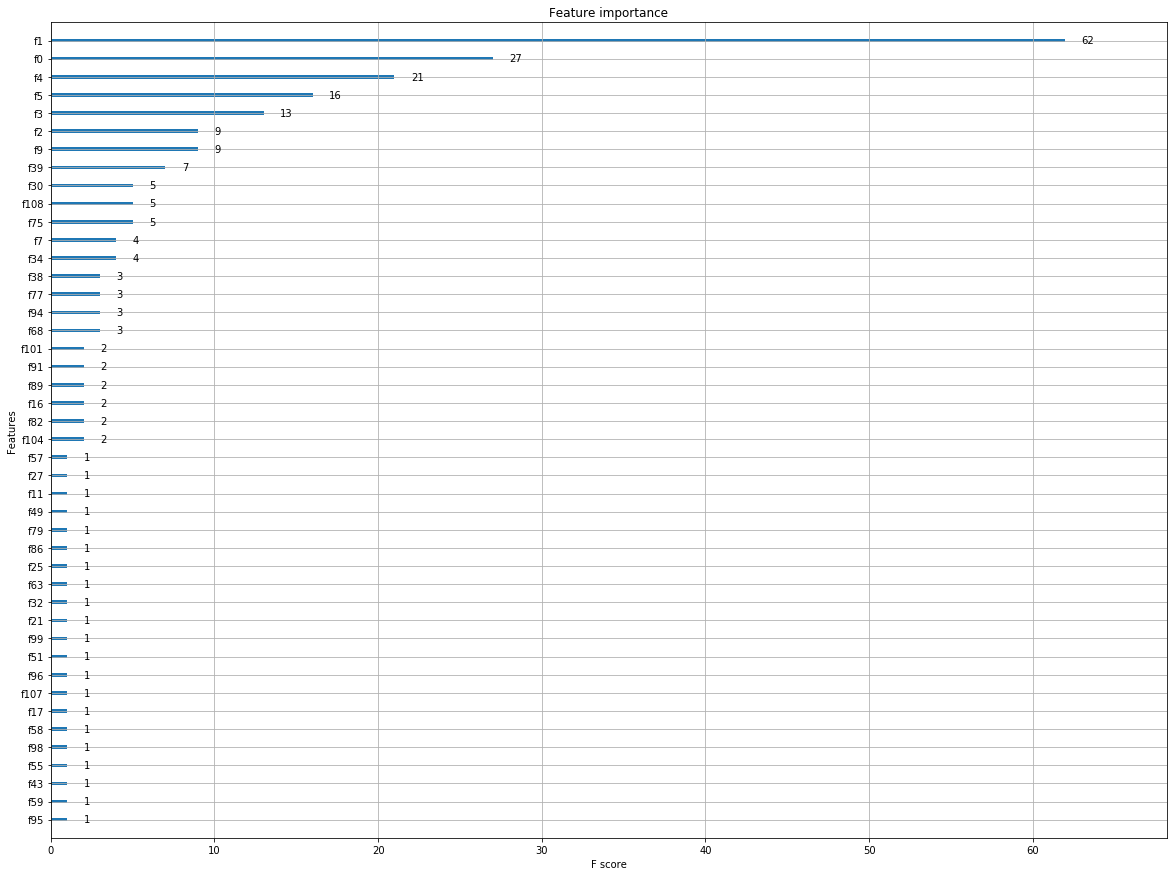

In [82]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [20,15]
plt.show()

In [15]:
gdbr = GradientBoostingRegressor(learning_rate=0.1, loss='lad', n_estimators=100, max_depth=2)
#rf = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1)
#abr = AdaBoostRegressor(DecisionTreeRegressor(), learning_rate=0.1, loss='linear', n_estimators=100)

In [16]:
cross_val(gdbr, X_train, y_train, 3)
#cross_val(rf, X_train, y_train, 5)
#cross_val(abr, X_train, y_train, 5)

GradientBoostingRegressor Train CV | MSE: 1501.842 | R2: 0.481


(1501.8422875809183, 0.4813125299230971)